In [1]:
import numpy as np
from utils import *
from classify_samples_MH import *
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import chi2
import seaborn as sns

## Read signals from file

In [2]:
error_not_distracted, u_signal_not_distracted, x_signal_not_distracted = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/x.csv')
error_distracted, u_signal_distracted, x_signal_distracted         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/x.csv')

person_idx = 0
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')
tc_test_col = tc_test[:, person_idx]

# combine the entire list in the priors
error_not_distracted_person = np.concatenate(error_not_distracted[person_idx])
u_not_distracted_person = np.concatenate(u_signal_not_distracted[person_idx])
x_not_distracted_person = np.concatenate(x_signal_not_distracted[person_idx])

# X_not_distracted = np.column_stack((error_not_distracted_person[:-1], u_not_distracted_person[:-1], x_not_distracted_person[:-1]))

X_not_distracted = np.column_stack((error_not_distracted_person, u_not_distracted_person))
                                                                                              
error_distracted_person = np.concatenate(error_distracted[person_idx])
u_distracted_person = np.concatenate(u_signal_distracted[person_idx])
x_distracted_person = np.concatenate(x_signal_distracted[person_idx])

# X_test = np.column_stack((error_distracted_person, u_distracted_person, x_distracted_person))
X_test = np.column_stack((error_distracted_person, u_distracted_person))

## Utility functions

In [3]:
def compute_distances_to_boundary(X_test, ocsvm):
    """
    Compute the signed distances of test samples to the decision boundary of a trained One-Class SVM.

    Parameters:
        X_test (numpy.ndarray): The test samples (shape: [n_samples, n_features]).
        ocsvm (OneClassSVM): A trained One-Class SVM model.

    Returns:
        distances (numpy.ndarray): Signed distances of the test samples to the decision boundary.
    """
    # Use the decision_function method to get distances
    distances = ocsvm.decision_function(X_test).ravel()  # Flatten to 1D array
    return distances

def transform_ocsvm_score(ocsvm_scores, alpha=1, threshold=-50):
    def sigmoid(score, threshold):
        """Transform score to probability using sigmoid function."""
        return 1 / (1 + np.exp(-alpha * (score - threshold)))
    
    # transform all the ocsvm scores
    transformed_scores = sigmoid(ocsvm_scores, threshold)
    return 1- transformed_scores

def normalize_mahalanobis(mahalanobis_distances, n_dimensions):
    """
    Normalize Mahalanobis distances based on a multivariate normal distribution.
    
    Parameters:
        mahalanobis_distances (array-like): Array of Mahalanobis distances.
        n_dimensions (int): Number of dimensions in the multivariate data.
        
    Returns:
        array-like: Array of normalized probabilities (fraction of samples inside or outside the score).
    """
    # Compute squared Mahalanobis distances
    mahalanobis_squared = np.array(mahalanobis_distances) ** 2
    
    # Compute probabilities based on the chi-squared distribution
    probabilities = chi2.cdf(mahalanobis_squared, df=n_dimensions)
    
    return probabilities

## Plot the test signals with the detection scores

In [4]:
def compute_ocsvm_distances_for_all(num_people=10, folder_name=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/'):
    """
    Compute OCSVM distances for multiple people and return as a 2D matrix.

    Parameters:
    - num_people (int): Number of people to compute distances for.
    - folder_name (str): Base folder path to load CSV files.

    Returns:
    - distances_matrix (numpy array): 2D array where each row corresponds to distances
                                       for one person.
    """
    # Initialize an empty list to hold distances for each person
    distances_matrix = []
    
    for person_idx in range(num_people):
        # Load the OCSVM model for the current person
        ocsvm = joblib.load(rf"/home/mihai/Thesis/Data/Models/ocsvm_model_{person_idx}.joblib")

        error_distracted, u_signal_distracted, x_signal_distracted = process_signals(
            error_file=f"{folder_name}e.csv", 
            u_file=f"{folder_name}u.csv", 
            x_file=f"{folder_name}x.csv"
        )

        error_distracted_person = np.concatenate(error_distracted[person_idx])
        u_distracted_person = np.concatenate(u_signal_distracted[person_idx])
        x_distracted_person = np.concatenate(x_signal_distracted[person_idx])
        X_test = np.column_stack((error_distracted_person, u_distracted_person))

        # Compute distances for the current person
        distances = compute_distances_to_boundary(X_test, ocsvm)
        distances_matrix.append(distances)
    
    # Convert the list of distances into a 2D numpy array
    distances_matrix = np.array(distances_matrix)
    return distances_matrix


# Example usage
# X_test is typically your distracted test data, passed as input or loaded in the function.
# distances_matrix = compute_ocsvm_distances_for_all(num_people=10, folder_name=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/')

# distances_matrix will be a 2D array where each row corresponds to one person.
# print("Distances Matrix:")
# print(distances_matrix)


In [5]:
# ocsvm_scores_matrix = np.array(distances_matrix)
# # save the scores
# np.savetxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores_distracted.csv', distances_matrix, delimiter=',')
# print(distances_matrix.shape)

## Read and plot the OCSVM distances matrix

In [6]:
# read from np.savetxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores.csv', ocsvm_scores_matrix, delimiter=',')
ocsvm_scores_matrix_not_distracted = np.loadtxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores_not_distracted.csv', delimiter=',').reshape(40,-1)

In [7]:
normalized_ocsvm = transform_ocsvm_score(ocsvm_scores_matrix_not_distracted, alpha=0.02)
mahalanobis_distances_not_distracted = np.loadtxt(r"/home/mihai/Thesis/MD_distances_per_run_not_distracted.csv", delimiter=',')
normalized_mahalanobis = normalize_mahalanobis(mahalanobis_distances_not_distracted, 3)

In [8]:
def plot_signals_with_highlight(tc, ocsvm, mahalanobis, time=None, label1="OCSVM", label2="Mahalanobis", title="Signals with Highlighted Distracted Intervals"):
    """
    Plots the signals tc, ocsvm, and mahalanobis with a highlighted region where tc equals 1.
    
    Parameters:
        tc (array-like): Binary signal (0 or 1).
        ocsvm (array-like): First signal to plot.
        mahalanobis (array-like): Second signal to plot.
        time (array-like, optional): Time array corresponding to the signals. If None, indices are used.
    """
    # Create a time array if not provided
    if time is None:
        time = np.arange(len(tc))
    
    plt.figure(figsize=(12, 5))
    
    # Highlight regions where tc == 1
    plt.fill_between(time, 0, 1, where=np.array(tc) == 1, 
                     color='lightblue', alpha=0.5, transform=plt.gca().get_xaxis_transform())
    
    # Plot ocsvm and mahalanobis signals with thinner lines
    plt.plot(time, ocsvm, label=label1, color="red", linewidth=1.0)
    plt.plot(time, mahalanobis, label=label2, color="green", linewidth=1.0)
    
    # Add labels, legend, and grid
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.title(title)
    plt.legend()
    plt.grid(True, linewidth=0.7)
    
    # Optimize layout and show plot
    plt.tight_layout()
    plt.show()

## Plot CUMSUM scores (processed Mahalanobis Distance)

In [9]:
def detect_distractions_mahalanobis_cusum(
        distances_distracted, 
        chi_squared_limit=0.8, 
        mean_not_distracted_shape=2, 
        evidence_threshold=1.5):
    """
    Detect distractions using a CUSUM algorithm based on Mahalanobis distances 
    and compute evidence as a function over time.
    
    Parameters:
        distances_distracted (array-like): Mahalanobis distances over time.
        chi_squared_limit (float): Chi-squared limit for distraction threshold.
        mean_not_distracted_shape (int): Degrees of freedom for chi-squared distribution.
        evidence_threshold (float): Threshold for accumulated evidence to detect distraction.

    Returns:
        distractions_detected (list): Indices where distractions are detected.
        evidence_function (list): Evidence level over time.
    """
    # Thresholds
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)
    threshold_reset = chi2.ppf(chi_squared_limit - 0.1, mean_not_distracted_shape)

    # Initialize variables
    S_pos = 0  # Positive cumulative sum (evidence)
    distractions_detected = []  # List to store timestamps of detected distractions
    distraction_active = False  # Whether distraction detection is currently paused
    evidence_function = []  # Evidence function over time

    # Loop through Mahalanobis distances
    for i, distance_value in enumerate(distances_distracted):
        if distraction_active:
            # Wait until the distance falls below the reset threshold
            if distance_value < threshold_reset:
                S_pos = 0  # Reset the cumulative sum
                distraction_active = False  # Resume checking distractions
            evidence_function.append(S_pos)  # Append current evidence level
            continue  # Skip further checks while in distraction mode

        # Accumulate evidence for upward shifts (distraction)
        if distance_value > threshold_distracted:
            S_pos += distance_value - threshold_distracted
        else:
            S_pos = 0  # Reset S_pos if the distance does not exceed the threshold

        # Check if evidence surpasses the detection threshold
        if S_pos > evidence_threshold:
            distractions_detected.append(i)  # Log the index where distraction is detected
            distraction_active = True  # Activate distraction mode
            S_pos = 0  # Reset cumulative sum for the next detection

        # Append current evidence level to the evidence function
        evidence_function.append(S_pos)

    return distractions_detected, evidence_function

In [10]:
def detect_distractions_mahalanobis_ewma(distances_distracted, chi_squared_limit=0.8, mean_not_distracted_shape=2, decay_factor=0.95):
    """
    Detect distractions using an exponentially weighted moving average (EWMA) of evidence based on Mahalanobis distances.
    
    Parameters:
        distances_distracted (array-like): Mahalanobis distances over time.
        chi_squared_limit (float): Chi-squared limit for distraction threshold.
        mean_not_distracted_shape (int): Degrees of freedom for chi-squared distribution.
        decay_factor (float): Decay factor for exponential weighting (0 < decay_factor < 1).
        
    Returns:
        evidence_function (list): Exponentially weighted evidence function over time.
    """
    # Threshold for distraction based on the chi-squared distribution
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)
    
    # Initialize variables
    evidence = 0  # Initial evidence value
    evidence_function = []  # Evidence function over time
    
    # Loop through Mahalanobis distances
    for distance_value in distances_distracted:
        # Update evidence using exponentially weighted average
        if distance_value > threshold_distracted:
            evidence = decay_factor * evidence + (1 - decay_factor) * (distance_value - threshold_distracted)
        else:
            evidence = decay_factor * evidence  # Decay evidence when no distraction
        
        # Store the current evidence value
        evidence_function.append(evidence)
    
    return evidence_function

In [11]:
def mahalanobis_evidence_accumulation_windowed(
        distances_distracted, 
        chi_squared_limit=0.8, 
        mean_not_distracted_shape=2, 
        window_size=20, 
        decay_factor=0.95):
    """
    Accumulate evidence over time using Mahalanobis distances, with a sliding window 
    and exponential decay.

    Parameters:
        distances_distracted (array-like): Mahalanobis distances over time.
        chi_squared_limit (float): Chi-squared limit for the threshold.
        mean_not_distracted_shape (int): Degrees of freedom for chi-squared distribution.
        window_size (int): Size of the sliding window.
        decay_factor (float): Exponential decay factor for evidence (0 < decay_factor < 1).

    Returns:
        evidence_function (list): Accumulated evidence over time.
    """
    # Compute the distraction threshold
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)

    # Initialize evidence function
    evidence_function = []
    num_samples = len(distances_distracted)

    # Iterate through the data using a sliding window
    for i in range(num_samples):
        # Define the current window
        window_start = max(0, i - window_size + 1)  # Ensure the window does not go negative
        window_end = i + 1  # Inclusive of the current point
        window = distances_distracted[window_start:window_end]
        
        # Compute evidence for the current window with exponential decay
        evidence = 0
        for j, distance in enumerate(reversed(window)):
            if distance > threshold_distracted:
                evidence += decay_factor**j * (distance - threshold_distracted)
            else:
                evidence += decay_factor**j * 0  # Decay evidence for points below the threshold
        
        # Append the accumulated evidence value for the current point
        evidence_function.append(evidence)

    return evidence_function

In [12]:
def detect_distractions_mahalanobis_ewma_windowed(
        distances_distracted, 
        chi_squared_limit=0.8, 
        mean_not_distracted_shape=2, 
        decay_factor=0.95, 
        window_size=20):
    """
    Detect distractions using an exponentially weighted moving average (EWMA) 
    of evidence based on Mahalanobis distances, restricted to a sliding window.
    
    Parameters:
        distances_distracted (array-like): Mahalanobis distances over time.
        chi_squared_limit (float): Chi-squared limit for distraction threshold.
        mean_not_distracted_shape (int): Degrees of freedom for chi-squared distribution.
        decay_factor (float): Decay factor for exponential weighting (0 < decay_factor < 1).
        window_size (int): Size of the sliding window.
        
    Returns:
        evidence_function (list): Evidence function over time.
    """
    # Threshold for distraction based on the chi-squared distribution
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)
    
    # Initialize evidence function
    evidence_function = []
    num_samples = len(distances_distracted)

    # Iterate through the data using a sliding window
    for i in range(num_samples):
        # Define the current window
        window_start = max(0, i - window_size + 1)  # Ensure the window does not go negative
        window_end = i + 1  # Inclusive of the current point
        window = distances_distracted[window_start:window_end]
        
        # Compute EWMA within the current window
        evidence = 0  # Reset evidence for the window
        for distance in window:
            if distance > threshold_distracted:
                evidence = decay_factor * evidence + (1 - decay_factor) * (distance - threshold_distracted)
            else:
                evidence = decay_factor * evidence  # Decay evidence when no distraction
        
        # Append the evidence value for the current point
        evidence_function.append(evidence)
    
    return evidence_function

In [13]:
def exponential_window_accumulation(
        distances,
        window_size=20,
        decay_factor=0.95):
    """
    Accumulate values over time using exponential decay, within a sliding window.

    Parameters:
        distances (array-like): Values to accumulate over time.
        window_size (int): Size of the sliding window.
        decay_factor (float): Exponential decay factor (0 < decay_factor < 1).

    Returns:
        accumulated_values (list): Accumulated values over time.
    """
    # Initialize the accumulated values list
    accumulated_values = []
    num_samples = len(distances)

    # Iterate through the data using a sliding window
    for i in range(num_samples):
        # Define the current window
        window_start = max(0, i - window_size + 1)  # Ensure the window does not go negative
        window_end = i + 1  # Inclusive of the current point
        window = distances[window_start:window_end]
        
        # Compute accumulated value for the current window with exponential decay
        accumulated_value = 0
        for j, value in enumerate(reversed(window)):
            accumulated_value += decay_factor**j * value
        
        # Append the accumulated value for the current point
        accumulated_values.append(accumulated_value)

    return np.array(accumulated_values)


In [14]:
ocsvm_scores_matrix_distracted = np.loadtxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores.csv', delimiter=',').reshape(40,-1)
mahalanobis_distances_distracted = np.loadtxt(r"/home/mihai/Thesis/MD_distances_per_run.csv", delimiter=',')

idx = 0
evidence_function_ewma = detect_distractions_mahalanobis_ewma(mahalanobis_distances_not_distracted[idx], chi_squared_limit=0.5)
evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_not_distracted[idx], chi_squared_limit=0.7)
ocsvm_ewma_nd = exponential_window_accumulation(-ocsvm_scores_matrix_not_distracted/500, window_size=20, decay_factor=0.99)
ocsvm_ewma = exponential_window_accumulation(-ocsvm_scores_matrix_distracted/500, window_size=20, decay_factor=0.95)


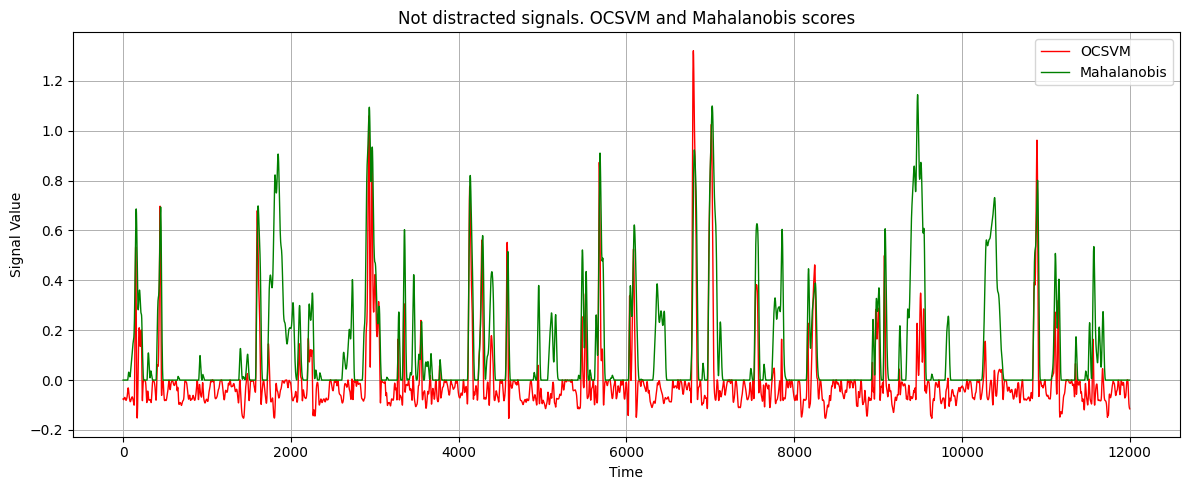

Run 0: mean of ocsvm: -0.0, var 0.02
Run 0: mean of mahalanobis: 0.12, var 0.05


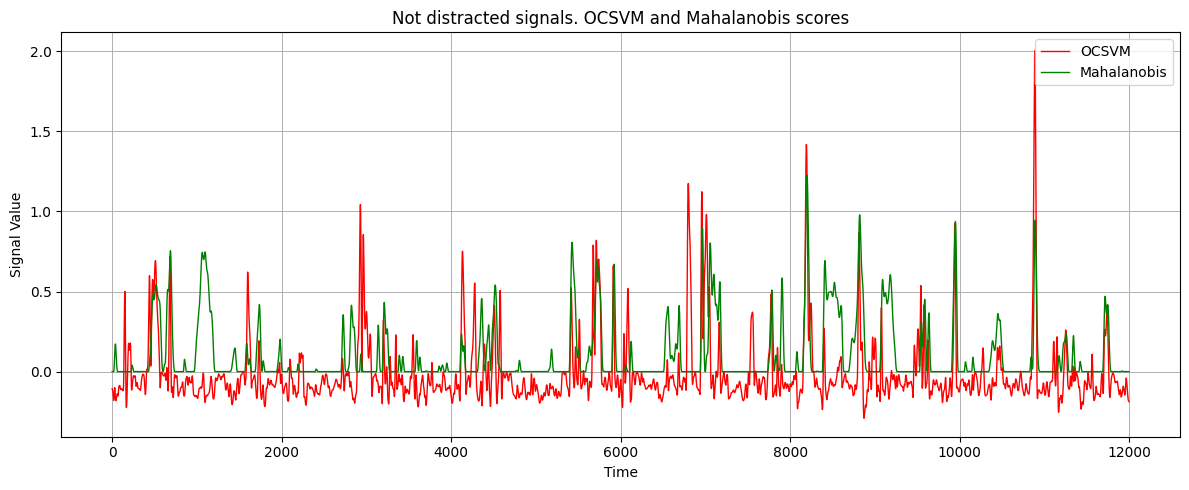

Run 1: mean of ocsvm: -0.01, var 0.02
Run 1: mean of mahalanobis: 0.1, var 0.04


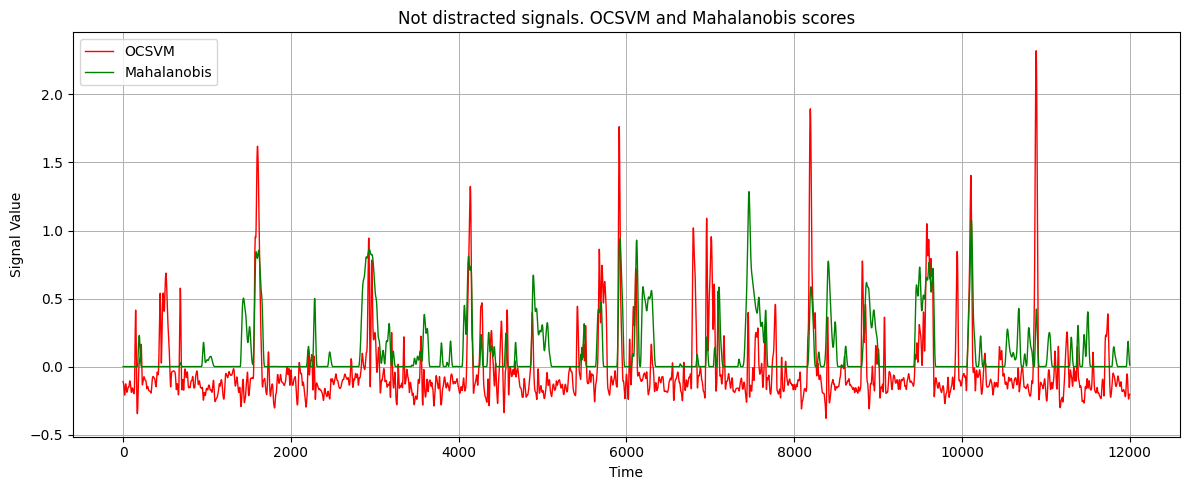

Run 2: mean of ocsvm: -0.01, var 0.02
Run 2: mean of mahalanobis: 0.11, var 0.04


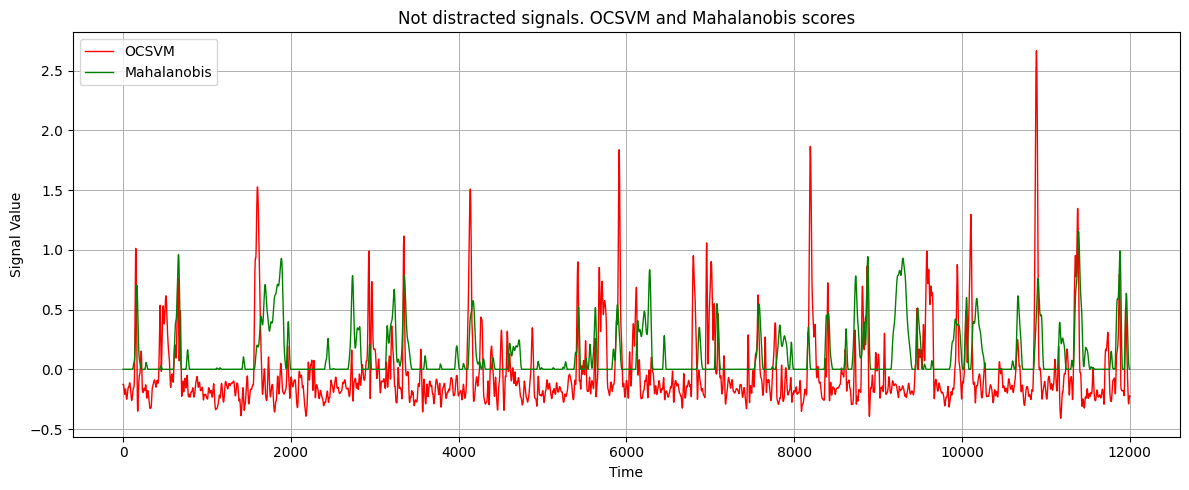

Run 3: mean of ocsvm: -0.01, var 0.02
Run 3: mean of mahalanobis: 0.11, var 0.04


In [15]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_not_distracted[idx], chi_squared_limit=0.6)
    analysed_ocsvm = -ocsvm_scores_matrix_not_distracted/500
    plot_signals_with_highlight(np.zeros(len(tc_test[:,idx])), ocsvm_ewma_nd[idx,:], evidence_function_ewma_windowed, title="Not distracted signals. OCSVM and Mahalanobis scores")
    # print the mean and var of the both plotted signals
    print(f"Run {idx}: mean of ocsvm: {np.round(np.mean(analysed_ocsvm[idx,:]),2)}, var {np.round(np.var(analysed_ocsvm[idx,:]),2)}")
    print(f"Run {idx}: mean of mahalanobis: {np.round(np.mean(evidence_function_ewma_windowed),2)}, var {np.round(np.var(evidence_function_ewma_windowed),2)}")

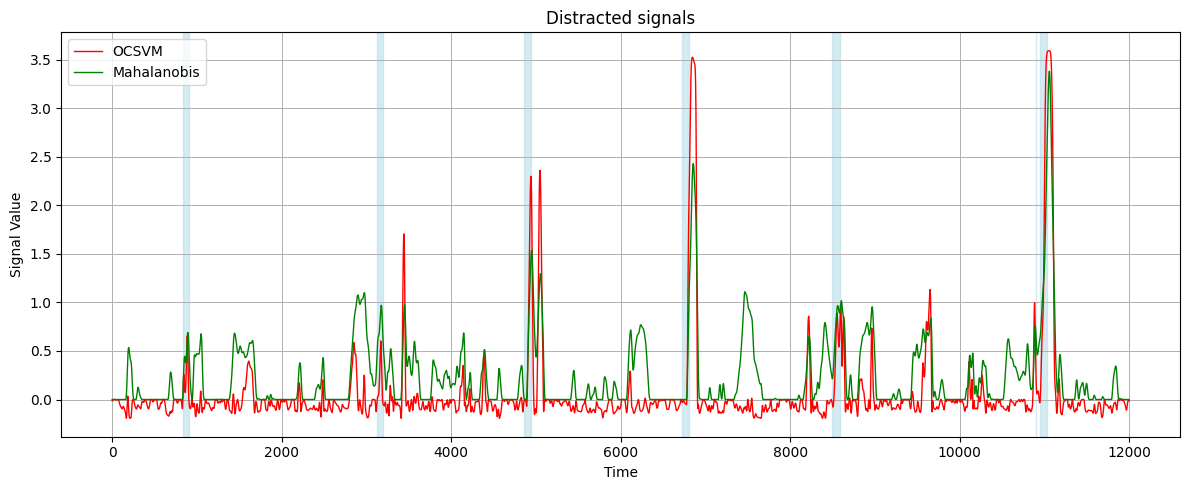

Run 0: mean of ocsvm: 0.06, var 0.23
Run 0: mean of mahalanobis: 0.23, var 0.16


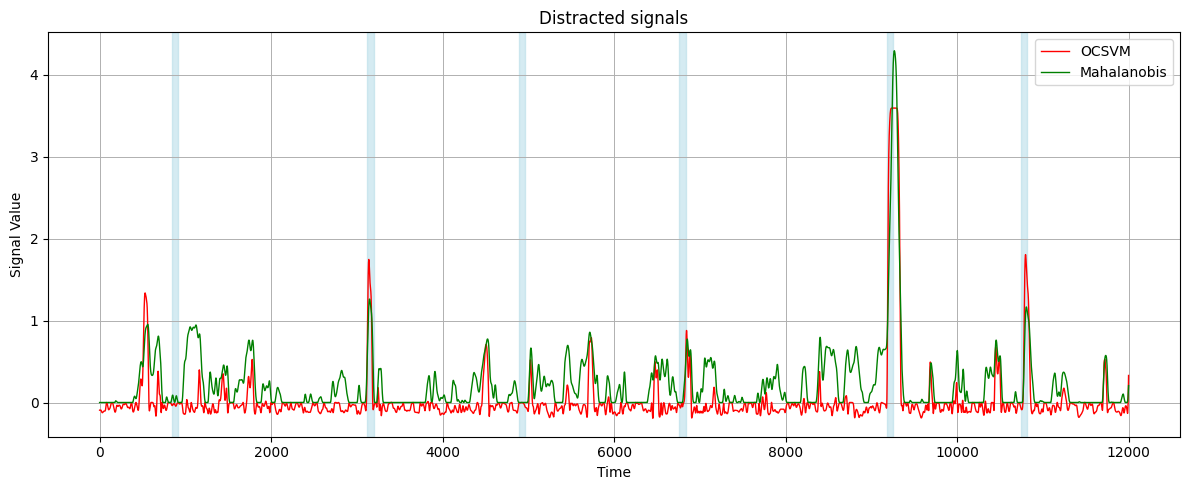

Run 1: mean of ocsvm: 0.03, var 0.18
Run 1: mean of mahalanobis: 0.22, var 0.17


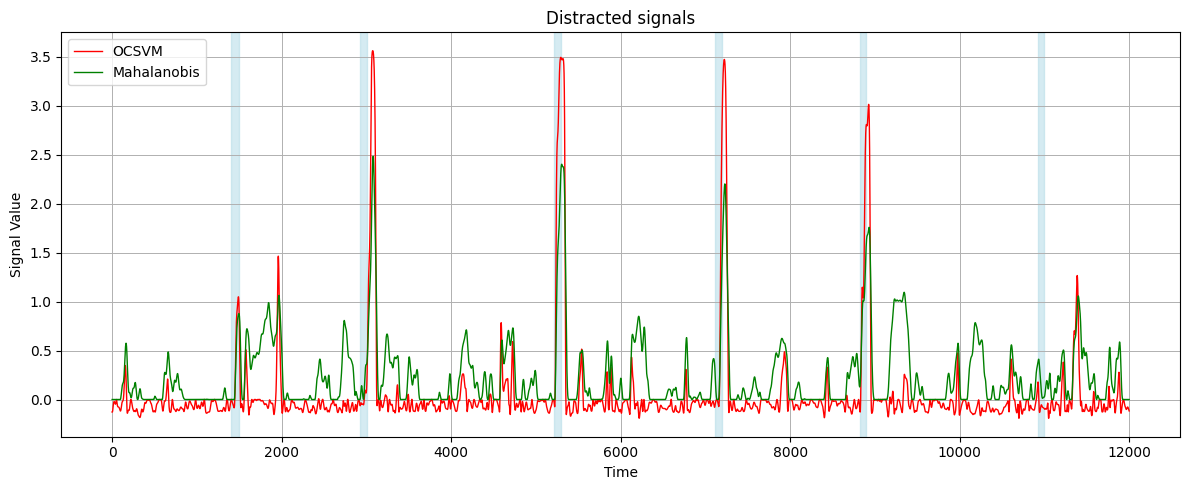

Run 2: mean of ocsvm: 0.06, var 0.27
Run 2: mean of mahalanobis: 0.24, var 0.14


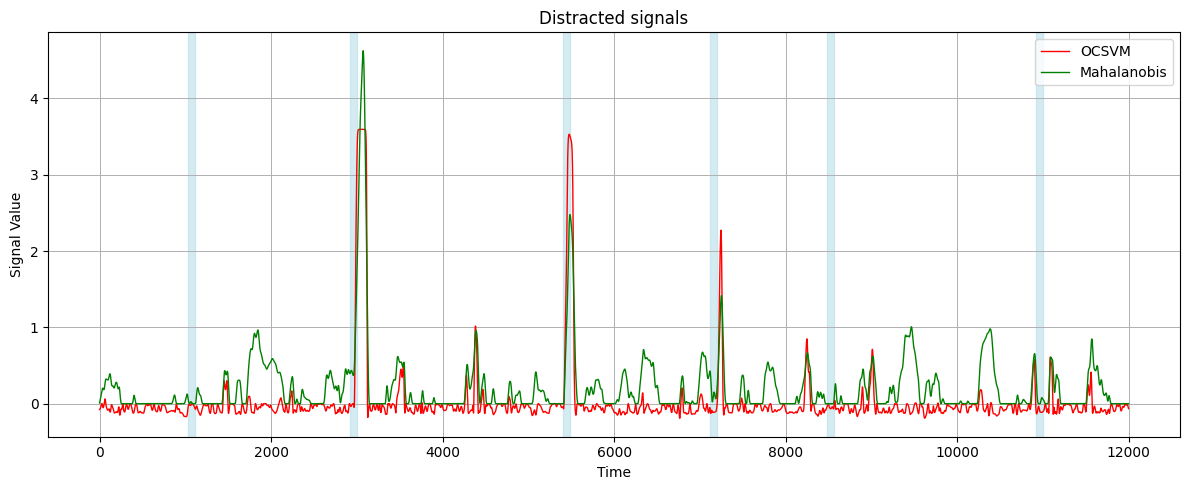

Run 3: mean of ocsvm: 0.03, var 0.23
Run 3: mean of mahalanobis: 0.21, var 0.19


In [16]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.5)
    analysed_ocsvm = -ocsvm_scores_matrix_distracted/500
    plot_signals_with_highlight(tc_test[:,idx], analysed_ocsvm[idx,:], evidence_function_ewma_windowed, title="Distracted signals")
    # print the mean and var of the both plotted signals
    print(f"Run {idx}: mean of ocsvm: {np.round(np.mean(analysed_ocsvm[idx,:]),2)}, var {np.round(np.var(analysed_ocsvm[idx,:]),2)}")
    print(f"Run {idx}: mean of mahalanobis: {np.round(np.mean(evidence_function_ewma_windowed),2)}, var {np.round(np.var(evidence_function_ewma_windowed),2)}")

## Analyse histograms of the distracted and not distracted OCSVM scores

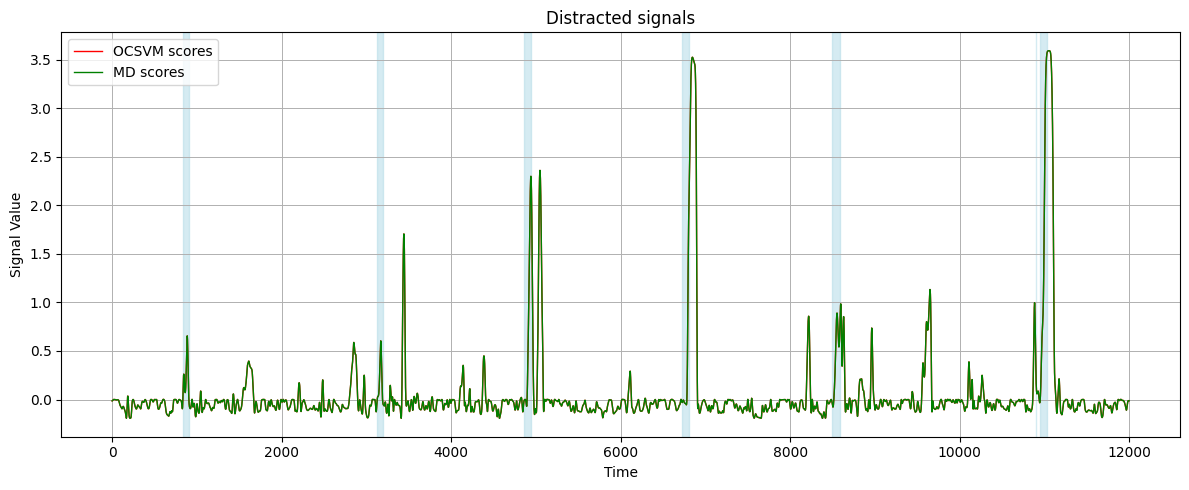

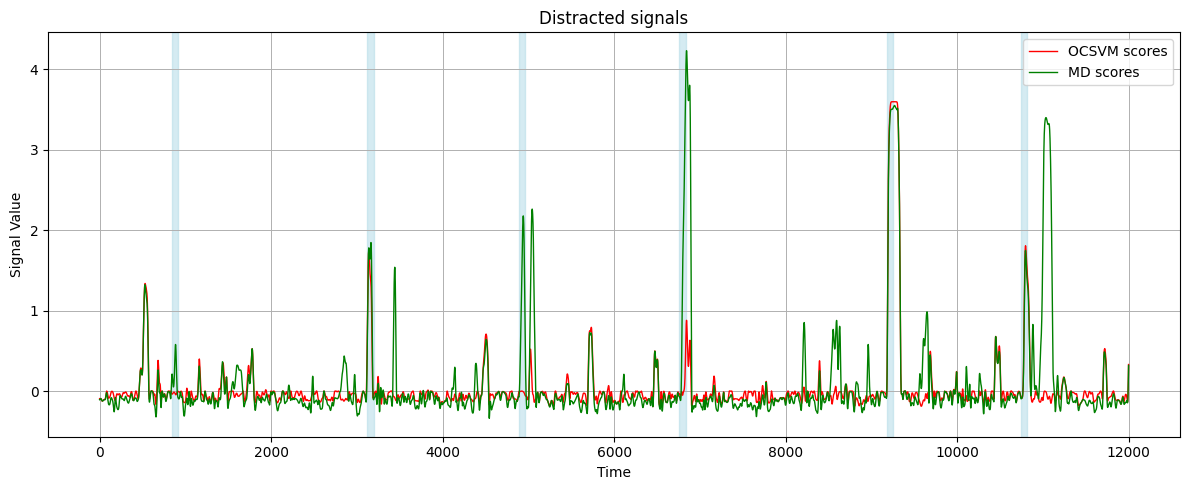

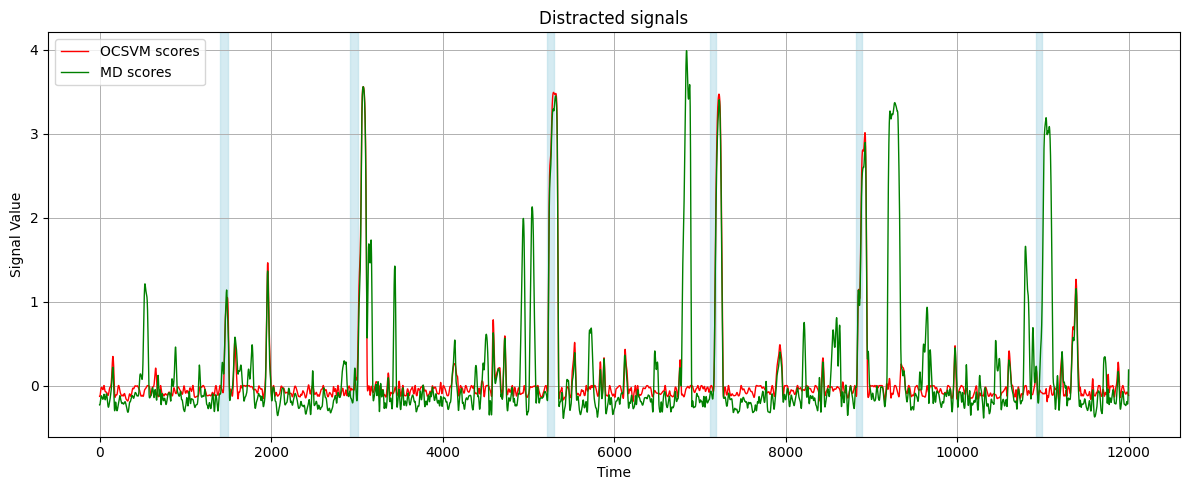

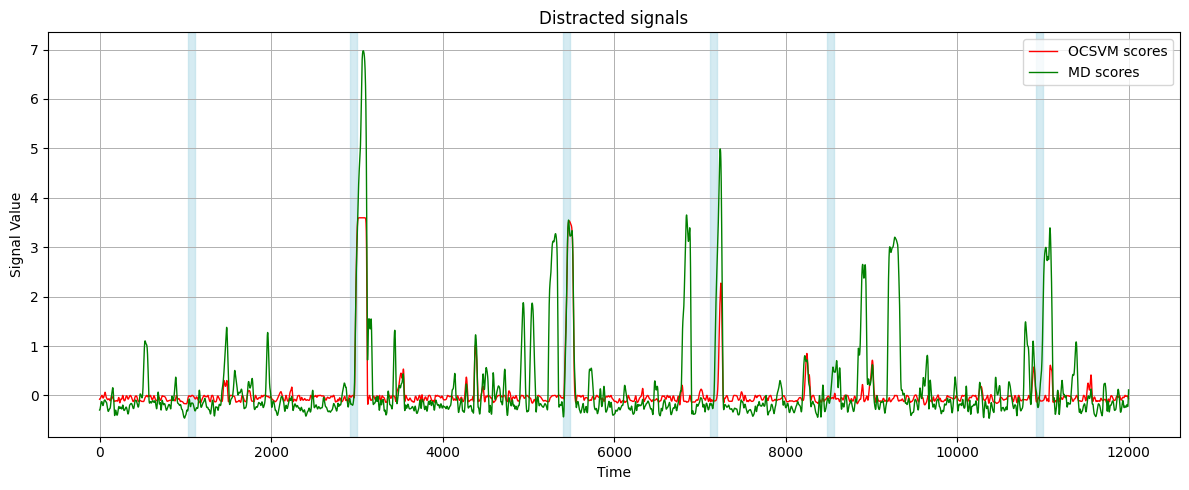

In [17]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.6)
    #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)

    plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], ocsvm_ewma[idx,:], label1="OCSVM scores", label2="MD scores", title="Distracted signals")
    # print the mean and var of the both plotted signals
    # print(f"Run {idx}: mean of ocsvm: {np.round(np.mean(normalized_ocsvm[idx,:]),2)}, var {np.round(np.var(normalized_ocsvm[idx,:]),2)}")
    # print(f"Run {idx}: mean of mahalanobis: {np.round(np.mean(evidence_function_ewma_windowed),2)}, var {np.round(np.var(evidence_function_ewma_windowed),2)}")

## Try to compute global metrics for the signal processing steps taken

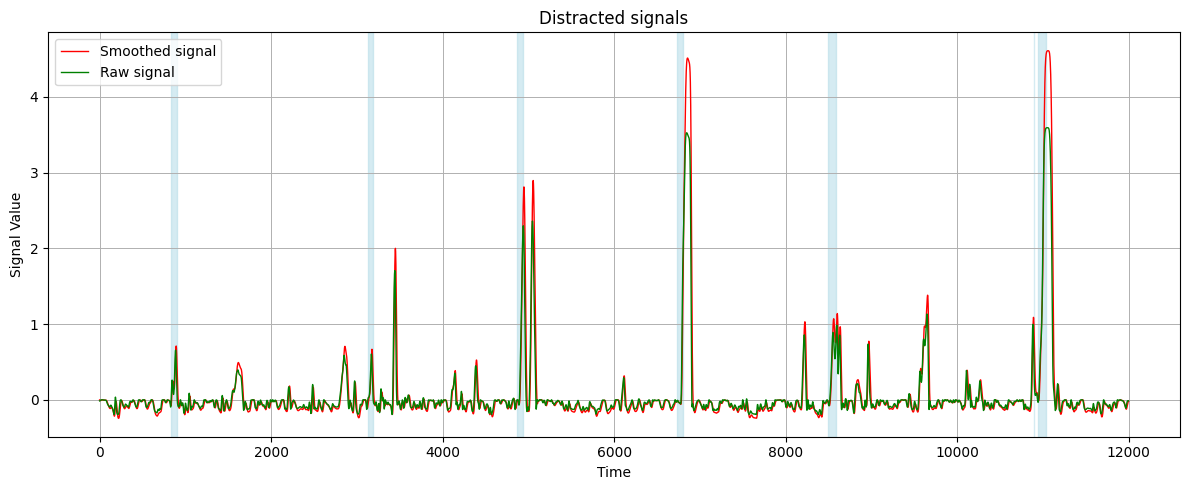

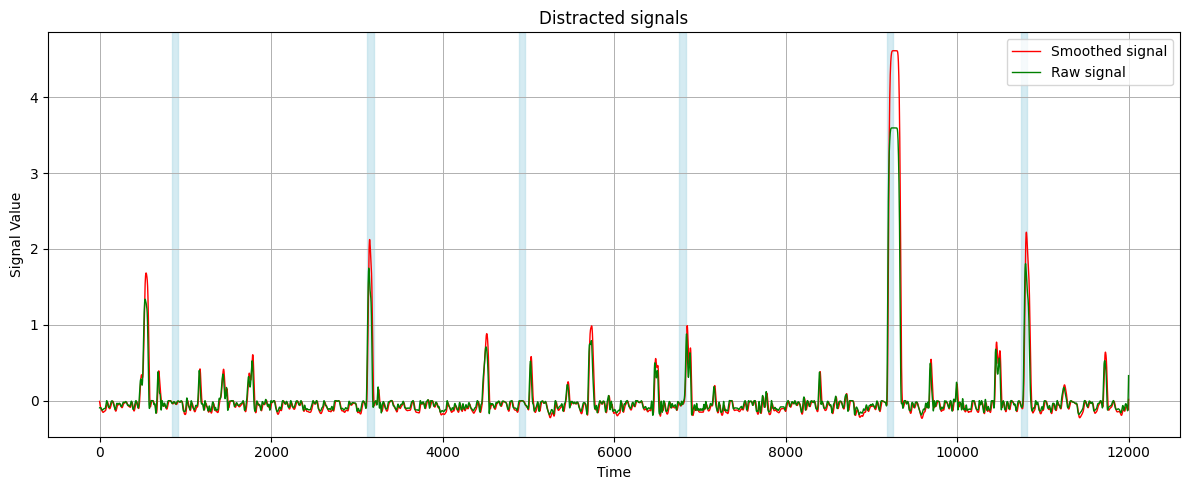

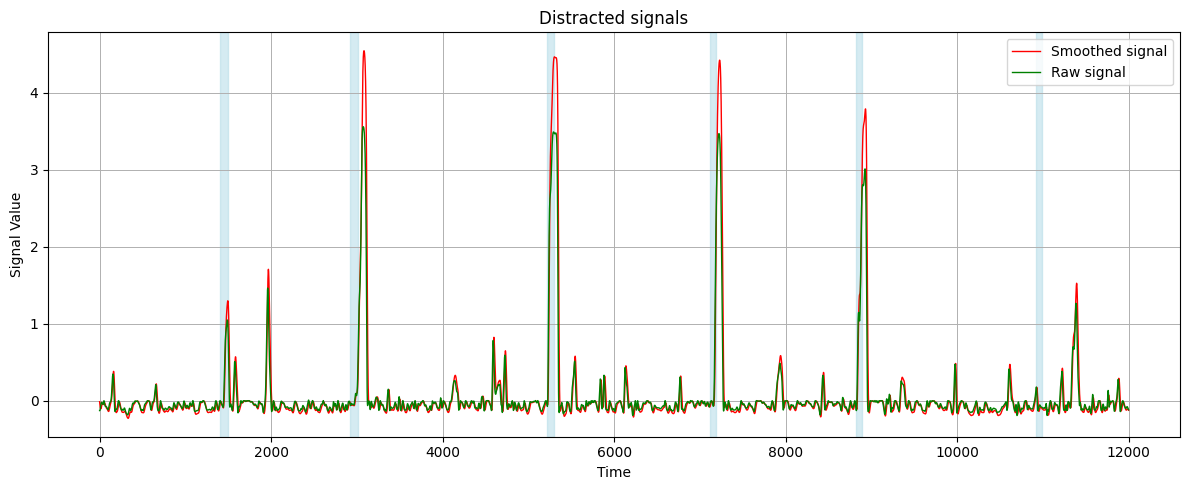

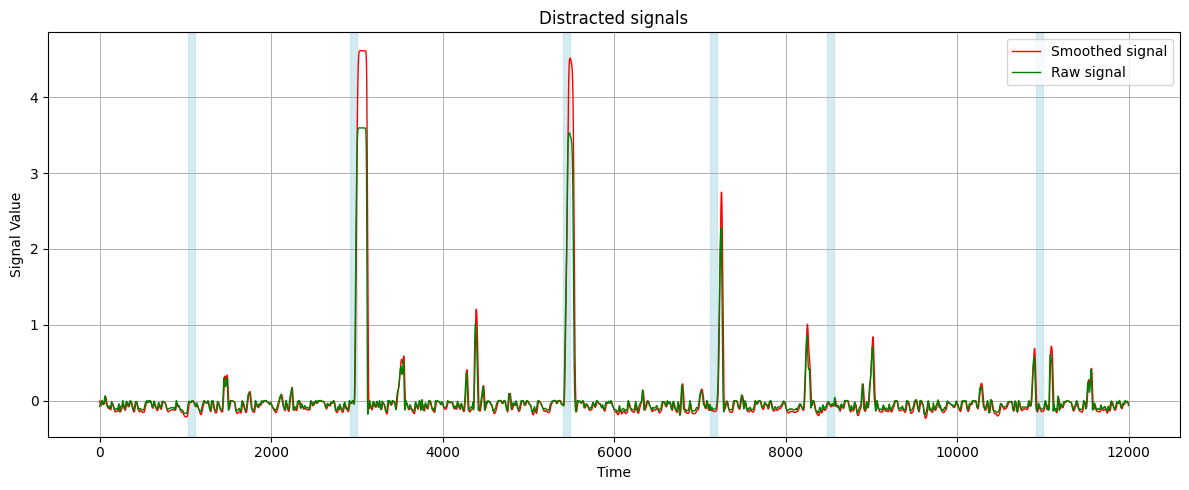

In [18]:
# try to get some global metric of smoothing the ocsvm scores

# what we would like to have: high peaks and energy in the distracted regions
# and low peaks and energy in the non-distracted regions
def exponential_window_accumulation(
        distances,
        window_size=20,
        decay_factor=0.95):
    """
    Accumulate values over time using exponential decay, within a sliding window.

    Parameters:
        distances (array-like): Values to accumulate over time.
        window_size (int): Size of the sliding window.
        decay_factor (float): Exponential decay factor (0 < decay_factor < 1).

    Returns:
        accumulated_values (list): Accumulated values over time.
    """
    # Initialize the accumulated values list
    accumulated_values = []
    num_samples = len(distances)

    # Iterate through the data using a sliding window
    for i in range(num_samples):
        # Define the current window
        window_start = max(0, i - window_size + 1)  # Ensure the window does not go negative
        window_end = i + 1  # Inclusive of the current point
        window = distances[window_start:window_end]
        
        # Compute accumulated value for the current window with exponential decay
        accumulated_value = 0
        for j, value in enumerate(reversed(window)):
            accumulated_value += decay_factor**j * value
        
        # Append the accumulated value for the current point
        accumulated_values.append(accumulated_value)

    return np.array(accumulated_values)

# ocsvm_ewma = exponential_window_accumulation(-ocsvm_scores_matrix_distracted/500, window_size=20, decay_factor=0.95)
for idx in range(4):
    ocsvm_ewma = exponential_window_accumulation(-ocsvm_scores_matrix_distracted[idx,:]/500, window_size=20, decay_factor=0.95) / 10
    plot_signals_with_highlight(tc_test[:,idx], ocsvm_ewma, -ocsvm_scores_matrix_distracted[idx,:]/500, title="Distracted signals", label1="Smoothed signal", label2="Raw signal")

In [19]:
# add an array 0.95, 0.95**2, 0.95**3 etc
arr = np.sum(np.array([0.95**i for i in range(20)]))
print(arr)

12.830281551829152


In [20]:
ocsvm_scores_not_distracted = np.loadtxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores_not_distracted.csv', delimiter=',').reshape(40,-1)
ocsvm_scores_distracted = np.loadtxt(r'/home/mihai/Thesis/Data/Models/ocsvm_scores.csv', delimiter=',').reshape(40,-1)

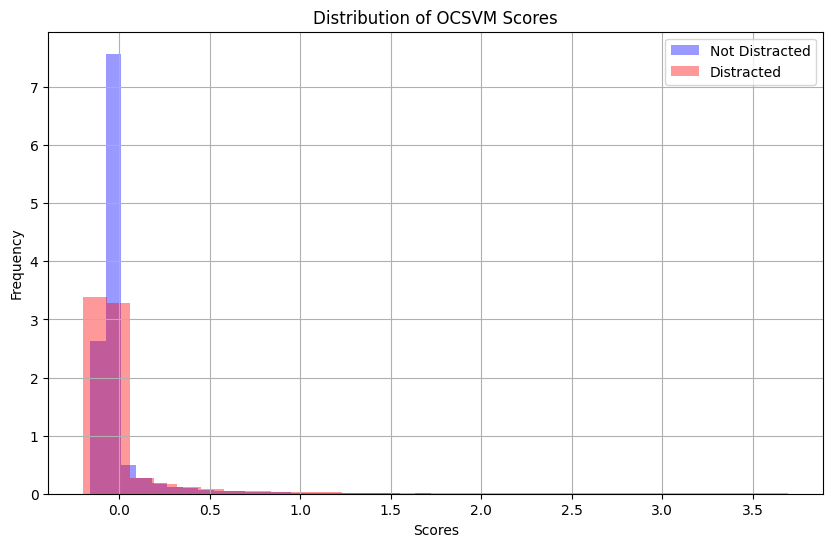

In [21]:
def plot_histograms_overlay(ocsvm_scores_not_distracted, ocsvm_scores_distracted, bins=30):
    """
    Plot histograms of two score matrices on top of each other.
    
    Parameters:
    - ocsvm_scores_not_distracted: Array-like, scores for the "not distracted" condition.
    - ocsvm_scores_distracted: Array-like, scores for the "distracted" condition.
    - bins: Number of bins to use for the histogram (default: 30).
    """
    # Flatten the matrices to 1D arrays for histogram plotting
    scores_not_distracted = np.ravel(ocsvm_scores_not_distracted)
    scores_distracted = np.ravel(ocsvm_scores_distracted)

    # Plot the histograms
    plt.figure(figsize=(10, 6))
    plt.hist(scores_not_distracted, bins=bins, alpha=0.4, label='Not Distracted', color='blue', density=True)
    plt.hist(scores_distracted, bins=bins, alpha=0.4, label='Distracted', color='red', density=True)
    
    # Add labels and title
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.title('Distribution of OCSVM Scores')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

plot_histograms_overlay(-ocsvm_scores_matrix_not_distracted/500, -ocsvm_scores_matrix_distracted/500, bins=30)

In [22]:
def select_samples(ocsvm_scores_distracted, tc_test):
    """
    Select samples from `ocsvm_scores_distracted` where the corresponding entries in `tc_test` are 1.

    Parameters:
    - ocsvm_scores_distracted: 2D NumPy array of distracted scores.
    - tc_test: 2D NumPy array of binary values (same shape as `ocsvm_scores_distracted`).

    Returns:
    - selected_samples: 1D NumPy array of selected samples from `ocsvm_scores_distracted`.
    """
    # Ensure the shapes match
    if ocsvm_scores_distracted.shape != tc_test.shape:
        raise ValueError("Shapes of ocsvm_scores_distracted and tc_test must match.")
    
    # Select the samples where tc_test == 1
    selected_samples = ocsvm_scores_distracted[tc_test == 1]
    return selected_samples

print(f"{tc_test.shape=}; {ocsvm_scores_matrix_distracted.shape=}")

ocsvm_scores_distracted_ones = select_samples(-ocsvm_scores_matrix_distracted/500, tc_test.T)

tc_test.shape=(12000, 40); ocsvm_scores_matrix_distracted.shape=(40, 12000)


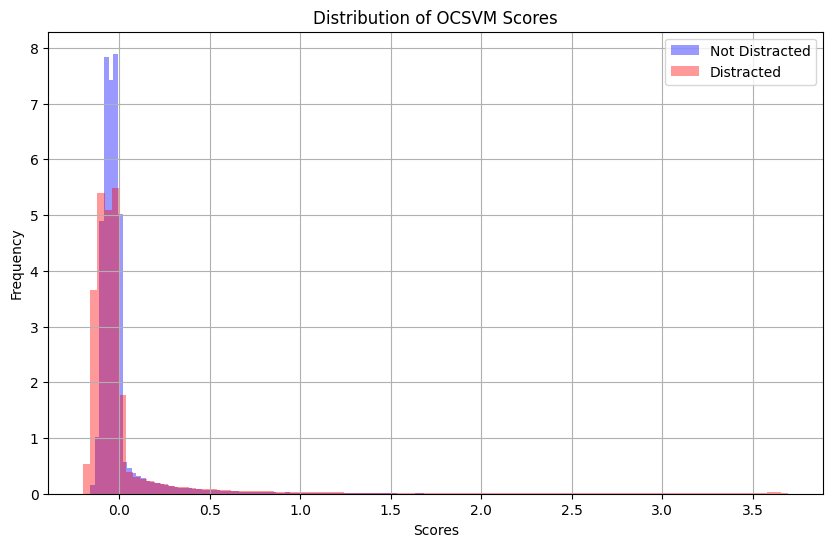

In [23]:
plot_histograms_overlay(-ocsvm_scores_matrix_not_distracted/500, -ocsvm_scores_matrix_distracted/500, bins=100)

## Mahalanobis distance histogram distribution

In [24]:
md_not_distracted = np.loadtxt(r"/home/mihai/Thesis/MD_distances_per_run_not_distracted.csv", delimiter=',')
md_distracted = np.loadtxt(r"/home/mihai/Thesis/MD_distances_per_run.csv", delimiter=',')

evidence_scores_not_distracted = []
evidence_scores_distracted = []

# process the signals
for idx in range(40):
    evidence_function_not_distracted = detect_distractions_mahalanobis_ewma_windowed(md_not_distracted[idx], chi_squared_limit=0.5)
    evidence_function_distracted = detect_distractions_mahalanobis_ewma_windowed(md_distracted[idx], chi_squared_limit=0.5)
    
    evidence_scores_not_distracted.append(evidence_function_not_distracted)
    evidence_scores_distracted.append(evidence_function_distracted)

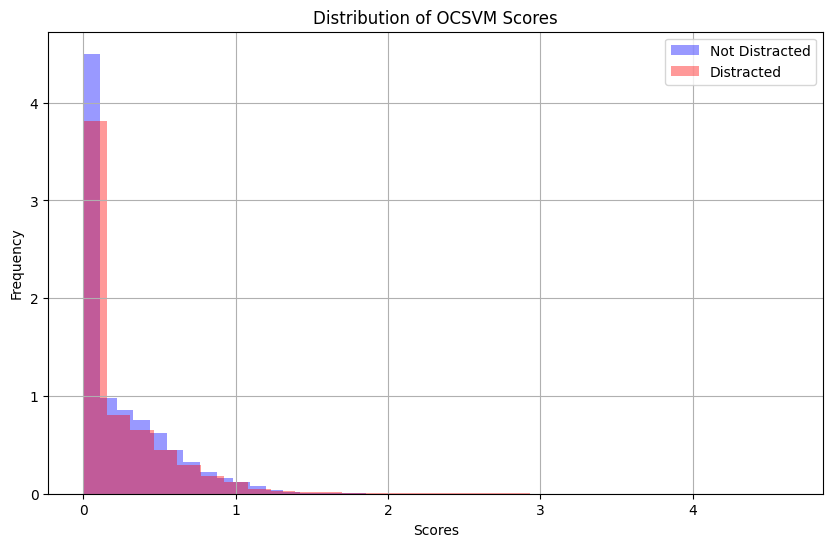

In [25]:
plot_histograms_overlay(np.array(evidence_scores_not_distracted), np.array(evidence_scores_distracted), bins=30)

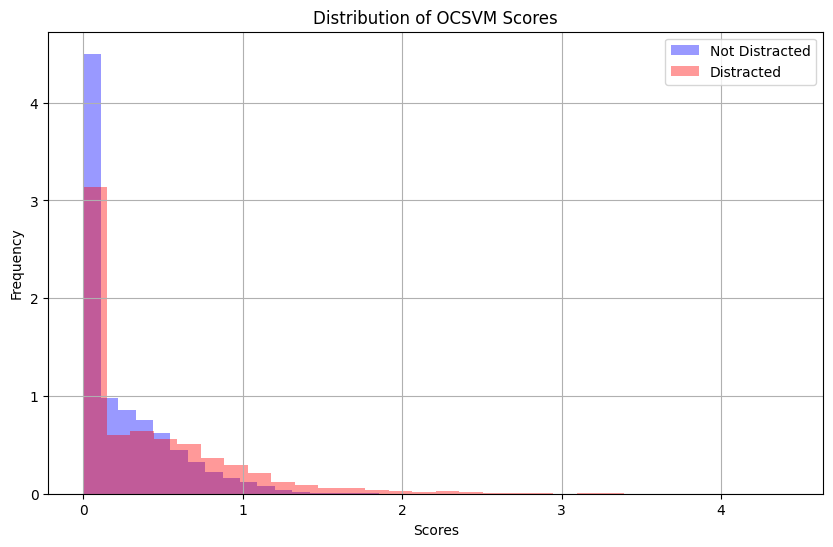

In [26]:
evidence_scores_distracted_ones = select_samples(np.array(evidence_scores_distracted), tc_test.T)
plot_histograms_overlay(np.array(evidence_scores_not_distracted), evidence_scores_distracted_ones, bins=30)

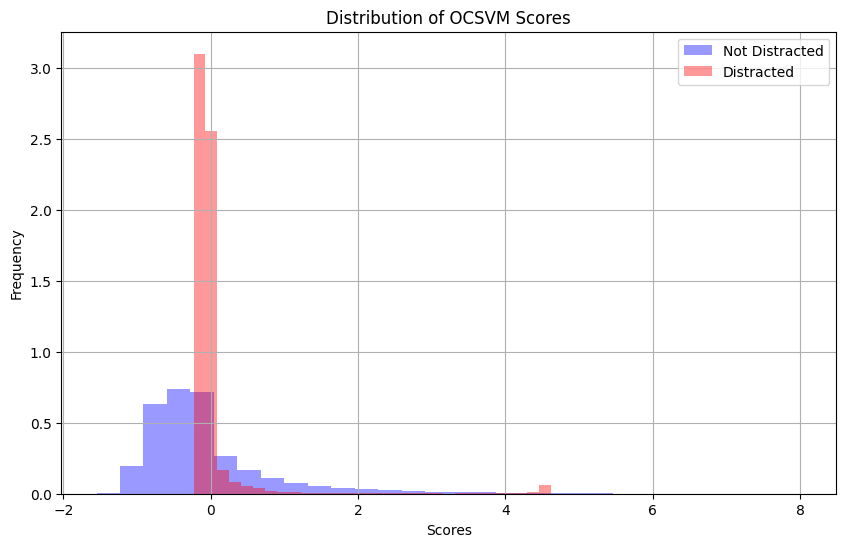

In [27]:
plot_histograms_overlay(ocsvm_ewma_nd, ocsvm_ewma, bins=30)

## Let's try combining the classifiers in some easy ways

ocsvm_ewma.shape=(40, 12000); mahalanobis_distances_distracted.shape=(40, 12000); ocsvm_scores_matrix_distracted.shape=(40, 12000)


ValueError: x and y must have same first dimension, but have shapes (40,) and (12000,)

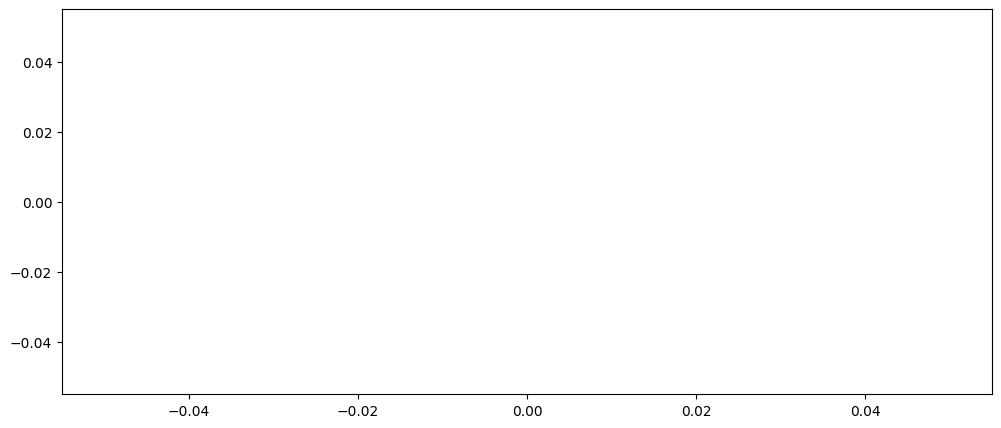

In [ ]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.6)
    #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)
    combined_classifiers =  (-ocsvm_scores_matrix_distracted/500)[idx,:] * evidence_function_ewma_windowed
    plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers, label1="OCSVM score", label2="Combined classifier (multiplication)", title="Distracted signals")
    # print the mean and var of the both plotted signals
    print(f"Run {idx}: mean of ocsvm: {np.round(np.mean(normalized_ocsvm[idx,:]),2)}, var {np.round(np.var(normalized_ocsvm[idx,:]),2)}")
    print(f"Run {idx}: mean of mahalanobis: {np.round(np.mean(evidence_function_ewma_windowed),2)}, var {np.round(np.var(evidence_function_ewma_windowed),2)}")

In [29]:
# ocsvm_ewma = exponential_window_accumulation(-ocsvm_scores_matrix_not_distracted/500, window_size=20, decay_factor=0.95)

# for idx in range(4):
#     evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_not_distracted[idx], chi_squared_limit=0.6)
#     #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)
#     combined_classifiers =  (-ocsvm_scores_matrix_not_distracted/500)[idx,:] * evidence_function_ewma_windowed
#     plot_signals_with_highlight(np.zeros(len(tc_test[:,idx])), (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers,
#                                 label1="OCSVM scores", label2="Combined classifiers score", title=f"Run {idx}. Not distracted signals. Combining by multiplying")

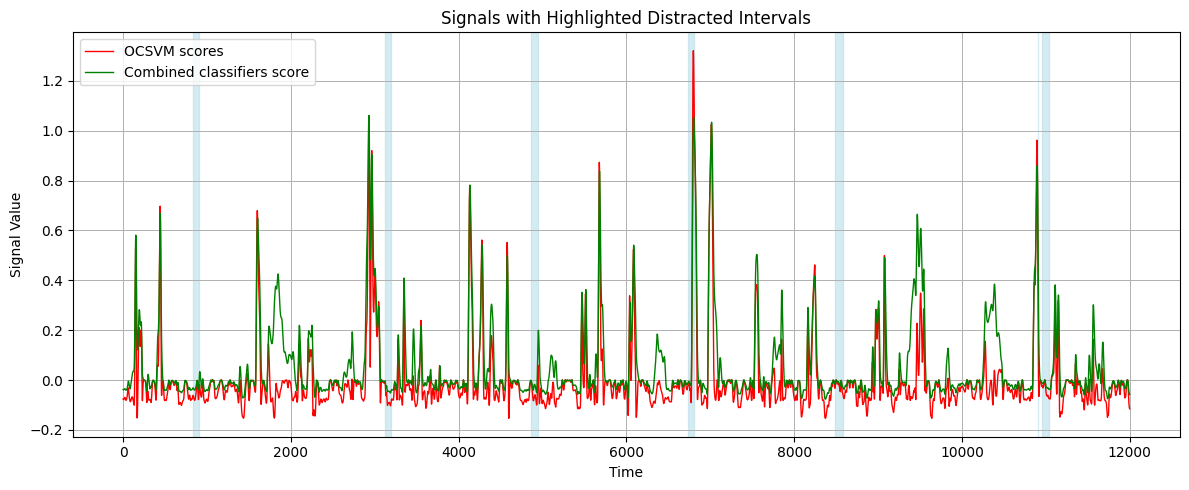

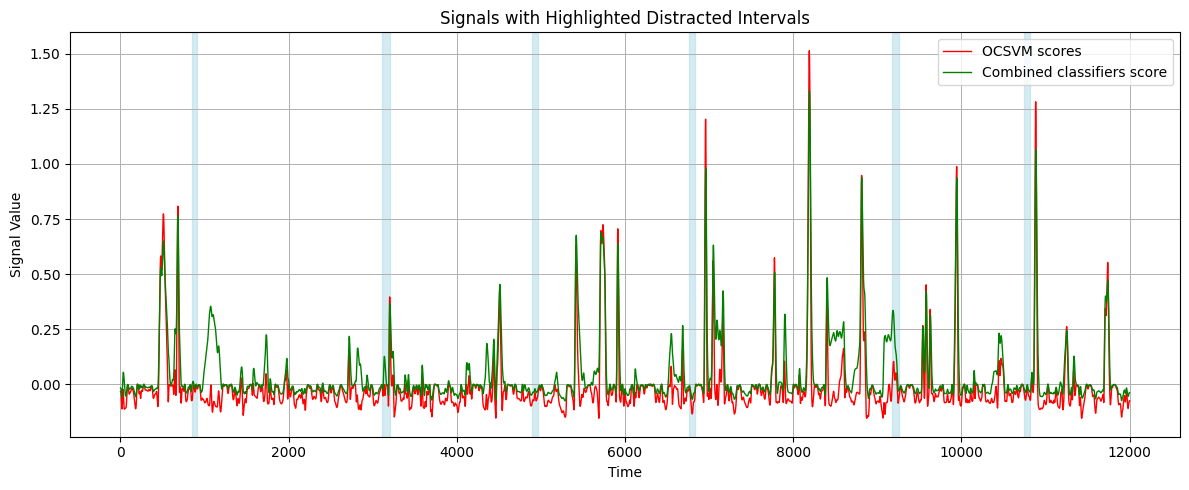

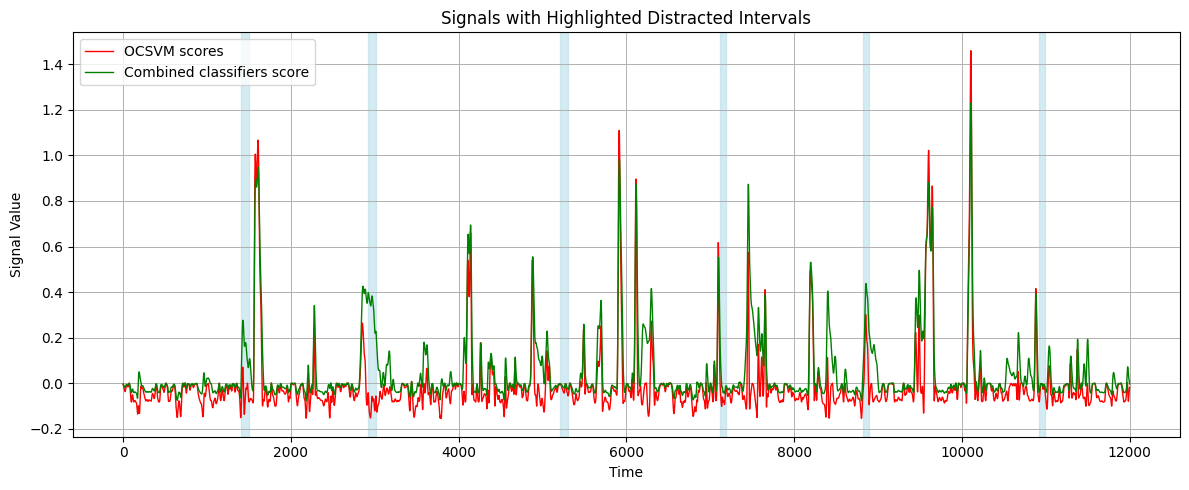

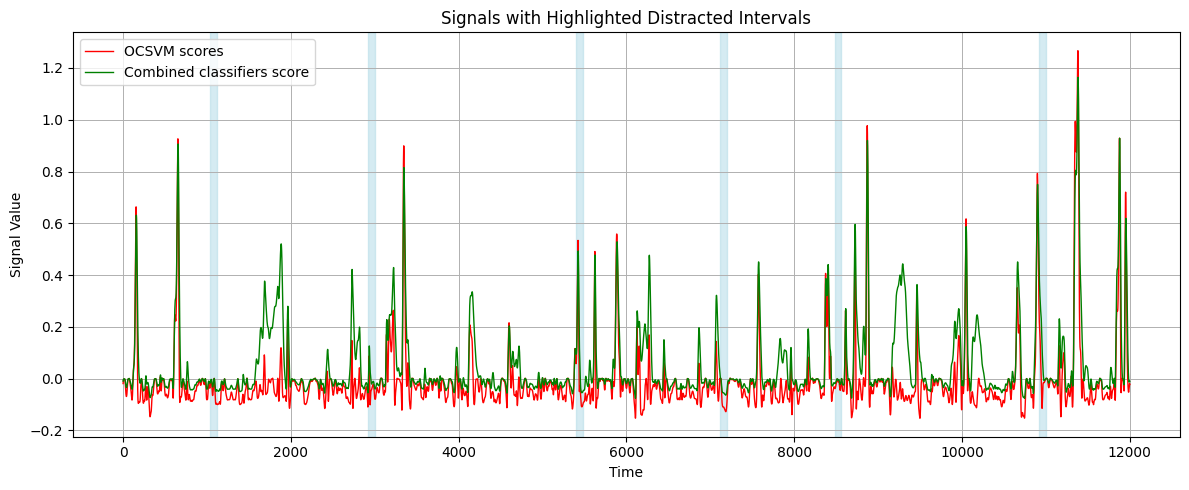

In [30]:
for idx in range(4):
    ocsvm_signal = ocsvm_scores_matrix_not_distracted
    md_signal = mahalanobis_distances_not_distracted

    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(md_signal[idx], chi_squared_limit=0.6)
    combined_classifiers =   ((-ocsvm_signal/500)[idx,:] + evidence_function_ewma_windowed) / 2

    plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_signal/500)[idx,:], combined_classifiers, label1="OCSVM scores", label2="Combined classifiers score")
   
    # plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers, title=f"Run {idx}. Not distracted signals")

In [31]:
# for idx in range(4):
#     evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.6)
#     #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)
#     combined_classifiers =  (-ocsvm_scores_distracted/500)[idx,:] * evidence_function_ewma_windowed
#     plot_signals_with_highlight(np.zeros(len(tc_test[:,idx])), (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers,
#                                 label1="OCSVM scores", label2="Combined classifiers score", title=f"Run {idx}. Not distracted signals. Combining by multiplying")

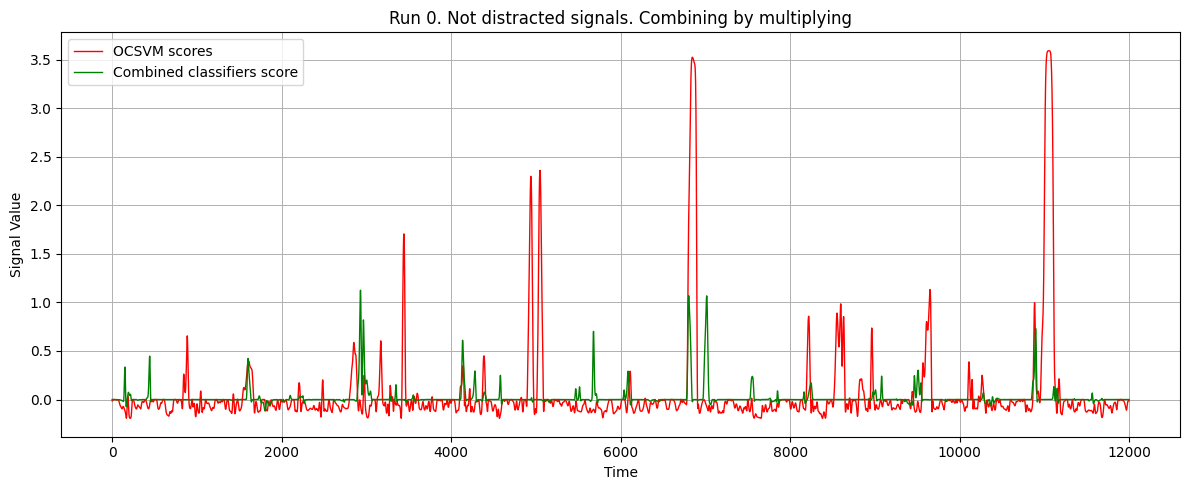

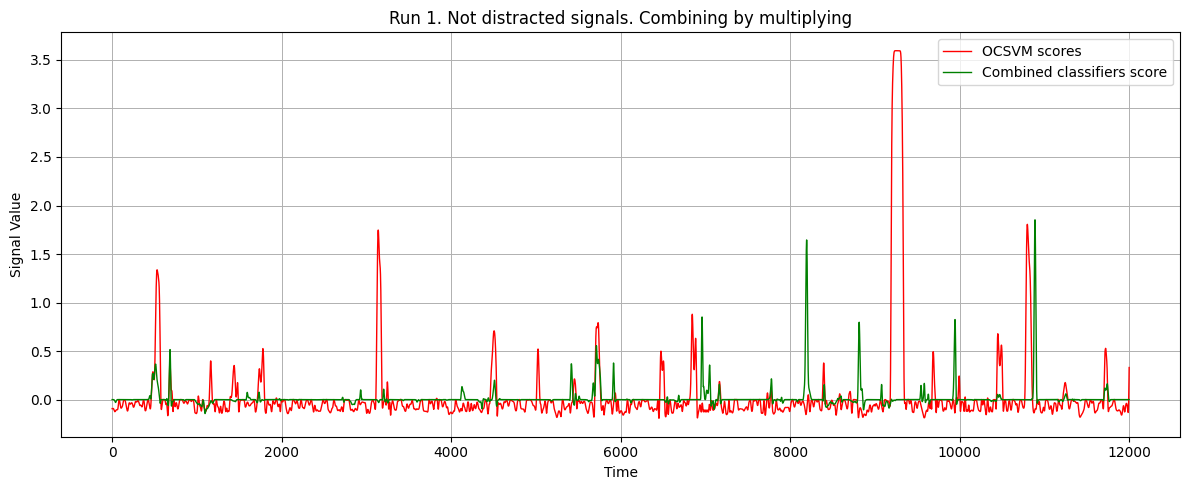

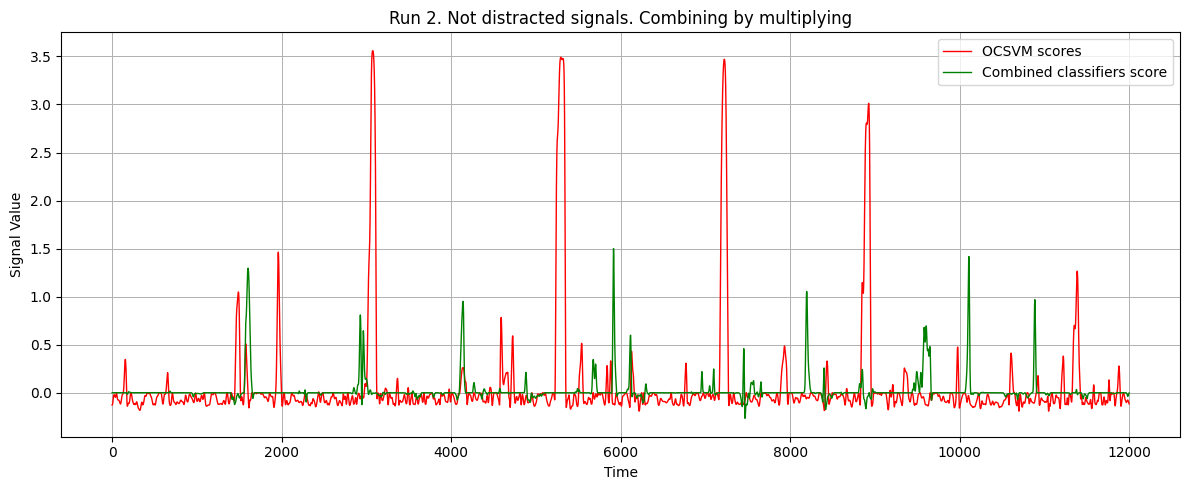

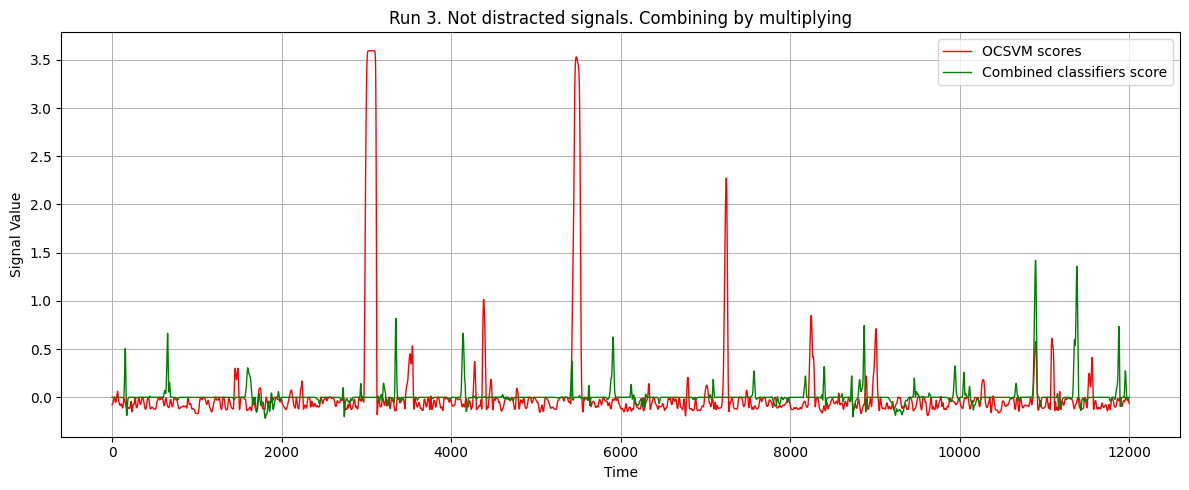

In [32]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_not_distracted[idx], chi_squared_limit=0.6)
    #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)
    combined_classifiers =  (ocsvm_ewma_nd)[idx,:] * evidence_function_ewma_windowed
    plot_signals_with_highlight(np.zeros(len(tc_test[:,idx])), (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers,
                                label1="OCSVM scores", label2="Combined classifiers score", title=f"Run {idx}. Not distracted signals. Combining by multiplying")

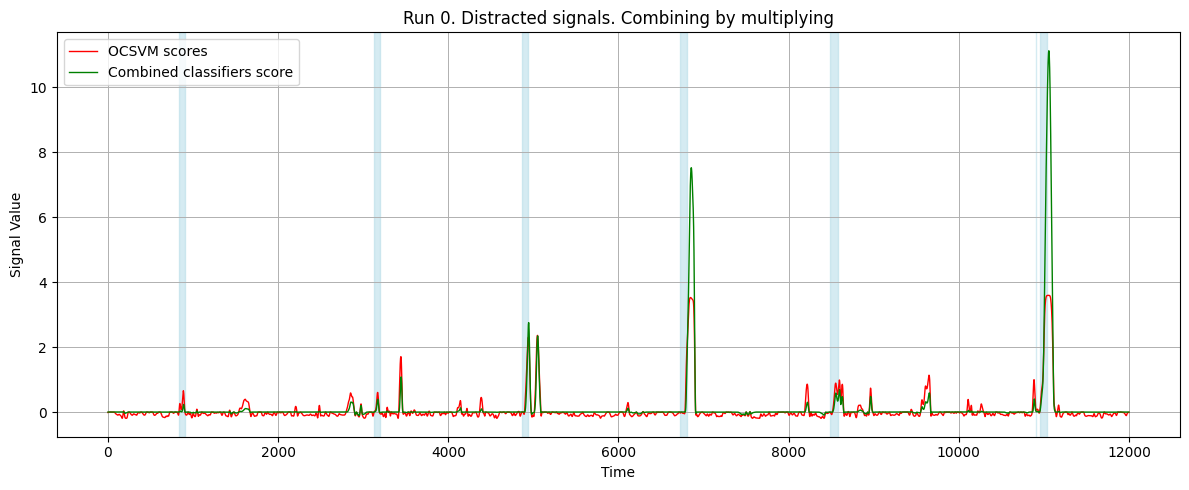

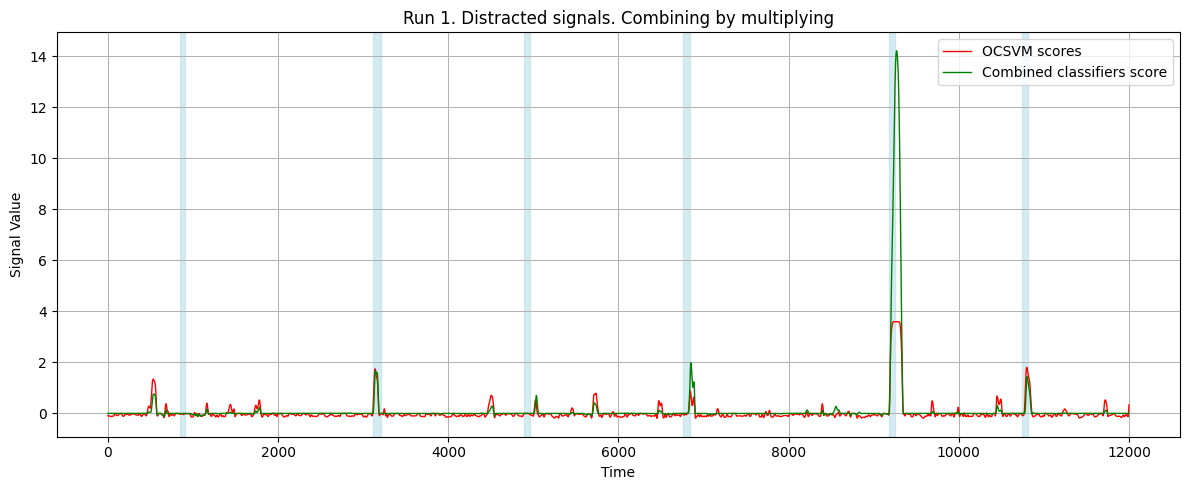

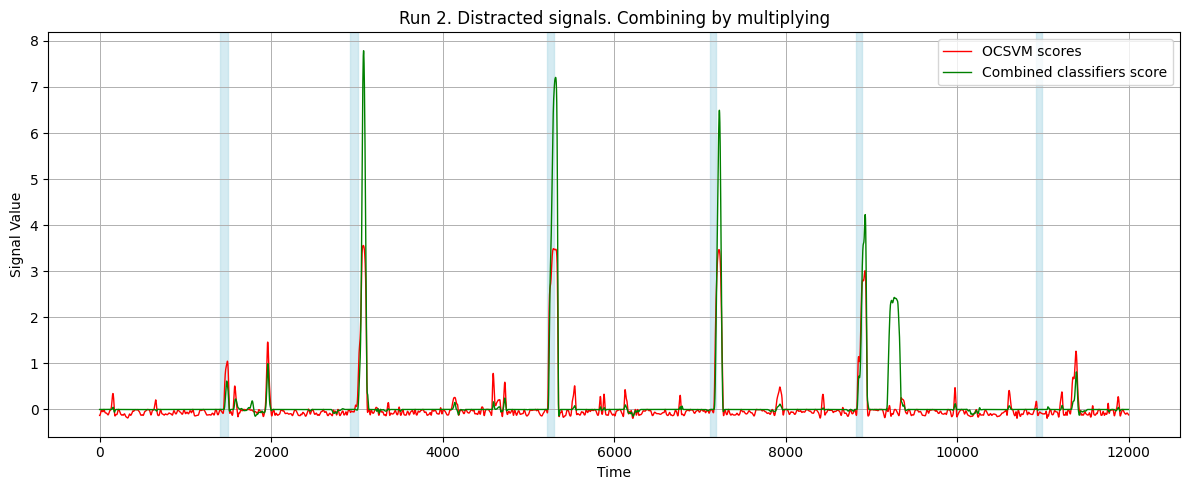

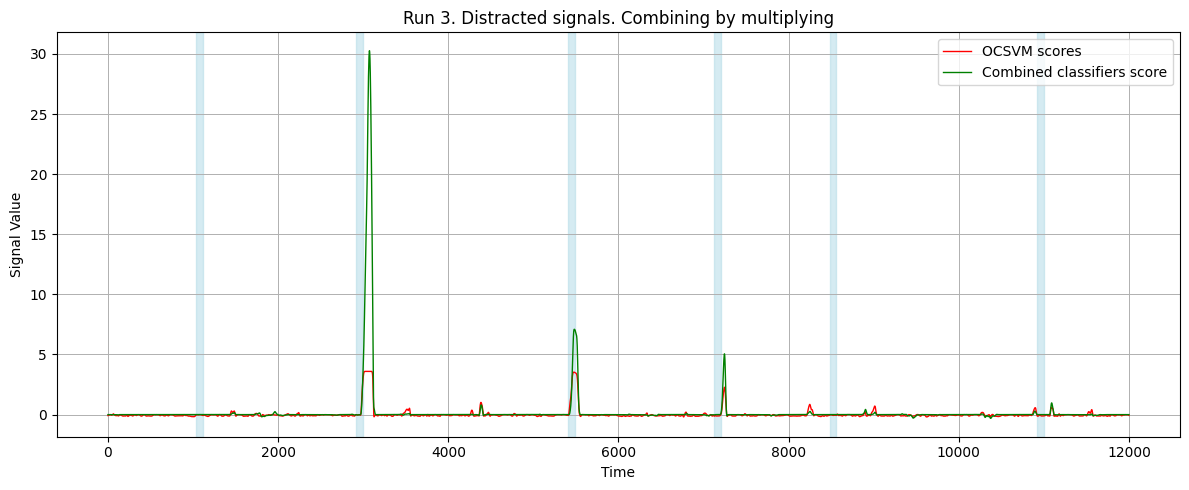

In [33]:
for idx in range(4):
    evidence_function_ewma_windowed = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.6)
    #plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], evidence_function_ewma_windowed)
    combined_classifiers =  (ocsvm_ewma)[idx,:] * evidence_function_ewma_windowed
    plot_signals_with_highlight(tc_test[:,idx], (-ocsvm_scores_matrix_distracted/500)[idx,:], combined_classifiers,
                                label1="OCSVM scores", label2="Combined classifiers score", title=f"Run {idx}. Distracted signals. Combining by multiplying")

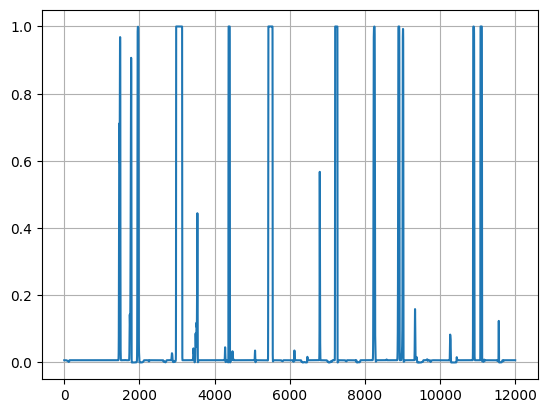

In [34]:
# try to normalize on a sigmoid the combined_classifiers signal
def sigmoid(score, threshold, alpha=0.01):
        """Transform score to probability using sigmoid function."""
        return 1 / (1 + np.exp(-alpha * (score - threshold)))

combined_classifiers_sigmoid = sigmoid(combined_classifiers, threshold=0.1, alpha=50)

plt.plot(combined_classifiers_sigmoid)
plt.grid()
plt.show()

## Experiment with stacking and adaboost on the decision stump

In [35]:
iso_forest_ocsvm = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest_ocsvm.fit(ocsvm_scores_matrix_not_distracted.reshape(-1, 1))

test_scores = iso_forest_ocsvm.decision_function(ocsvm_scores_matrix_distracted.reshape(-1, 1))

print(test_scores.shape)

(480000,)


In [36]:
# Initialize lists to store anomaly scores
train_anomaly_scores = []
test_anomaly_scores = []

# Train Isolation Forest for OCSVM scores
iso_forest_ocsvm = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest_ocsvm.fit(ocsvm_scores_matrix_not_distracted.reshape(-1, 1))

# Get anomaly scores for OCSVM model
train_anomaly_scores.append(iso_forest_ocsvm.decision_function(ocsvm_scores_matrix_not_distracted.reshape(-1, 1)))
test_anomaly_scores.append(iso_forest_ocsvm.decision_function(ocsvm_scores_matrix_distracted.reshape(-1, 1)))

# Train Isolation Forest for Mahalanobis distances
iso_forest_mahalanobis = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest_mahalanobis.fit(mahalanobis_distances_not_distracted.reshape(-1, 1))

# Get anomaly scores for Mahalanobis model
train_anomaly_scores.append(iso_forest_mahalanobis.decision_function(mahalanobis_distances_not_distracted.reshape(-1, 1)))
test_anomaly_scores.append(iso_forest_mahalanobis.decision_function(mahalanobis_distances_distracted.reshape(-1, 1)))

# Stack anomaly scores (combine into a single feature set for stacking)
stacked_train_features = np.column_stack(train_anomaly_scores)
stacked_test_features = np.column_stack(test_anomaly_scores)

(480000,)
(480000,)


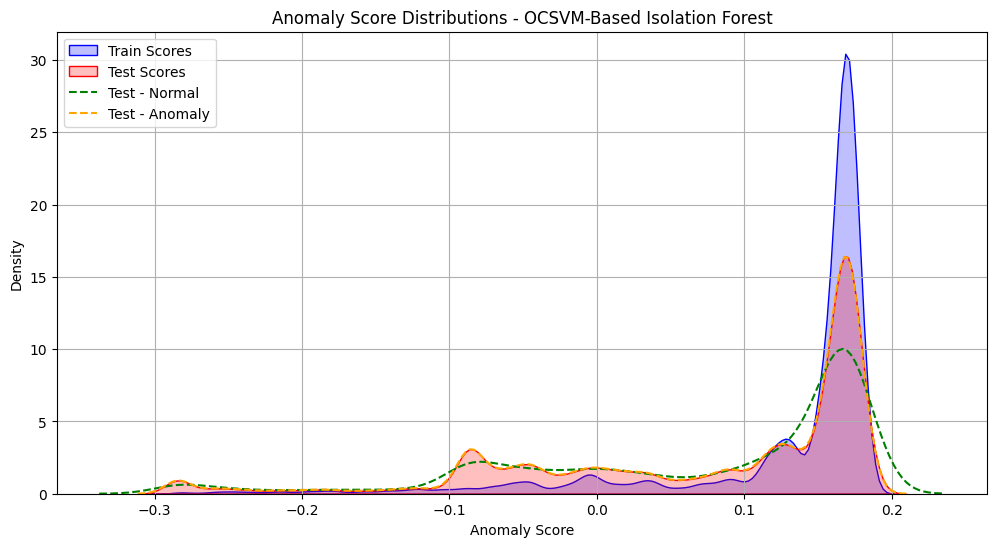

(480000,)
(480000,)


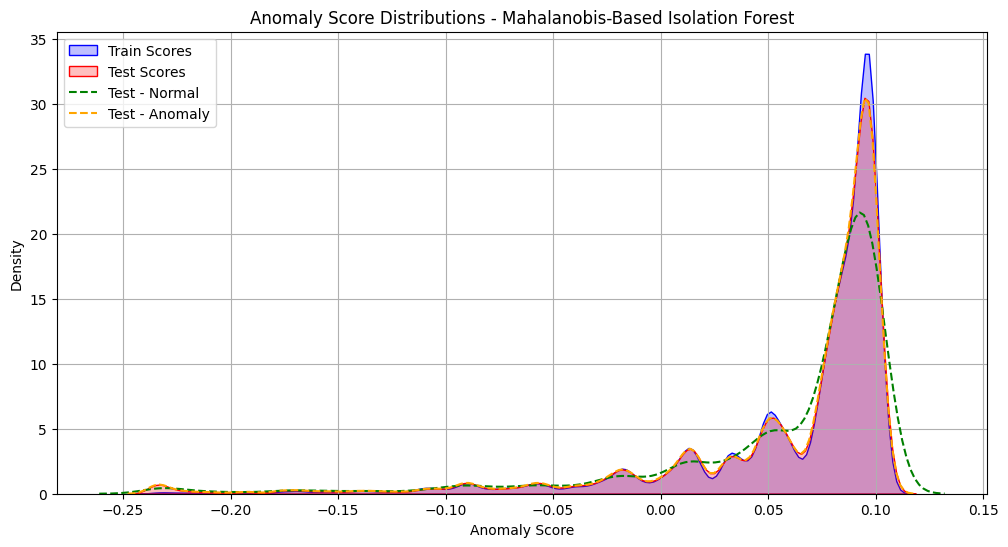

(480000,)
(480000,)


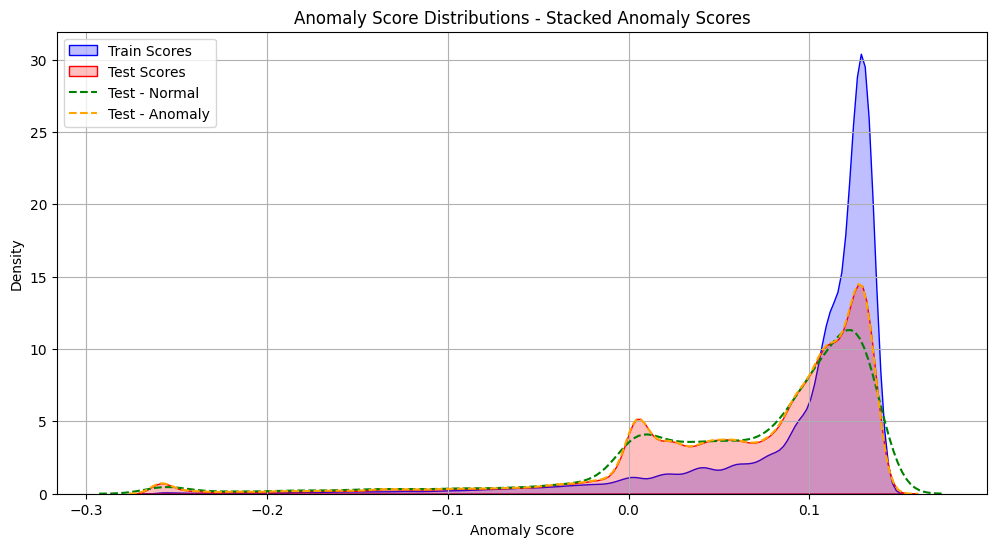

In [37]:

# Plotting function for anomaly score distributions
def plot_anomaly_score_distributions(train_scores, test_scores, labels_test=None, model_name="Model"):
    plt.figure(figsize=(12, 6))
    
    # Plot training scores
    sns.kdeplot(train_scores, label="Train Scores", color="blue", shade=True)
    
    # Plot test scores
    sns.kdeplot(test_scores, label="Test Scores", color="red", shade=True)
    
    print(test_scores.shape)
    print(labels_test.shape)
    # Overlay labels if available
    if labels_test is not None:
        sns.kdeplot(test_scores[labels_test == 1], label="Test - Normal", color="green", linestyle="--")
        sns.kdeplot(test_scores[labels_test == 0], label="Test - Anomaly", color="orange", linestyle="--")
    
    plt.title(f"Anomaly Score Distributions - {model_name}")
    plt.xlabel("Anomaly Score")
    plt.grid()
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Analyze OCSVM Isolation Forest scores
plot_anomaly_score_distributions(
    train_scores=train_anomaly_scores[0],
    test_scores=test_anomaly_scores[0],
    labels_test=tc_test.ravel(),
    model_name="OCSVM-Based Isolation Forest"
)

# Analyze Mahalanobis Isolation Forest scores
plot_anomaly_score_distributions(
    train_scores=train_anomaly_scores[1],
    test_scores=test_anomaly_scores[1],
    labels_test=tc_test.ravel(),
    model_name="Mahalanobis-Based Isolation Forest"
)

# Analyze Stacked Model scores
plot_anomaly_score_distributions(
    train_scores=stacked_train_features.mean(axis=1),  # Mean of train scores
    test_scores=stacked_test_features.mean(axis=1),   # Mean of test scores
    labels_test=tc_test.ravel(),
    model_name="Stacked Anomaly Scores"
)


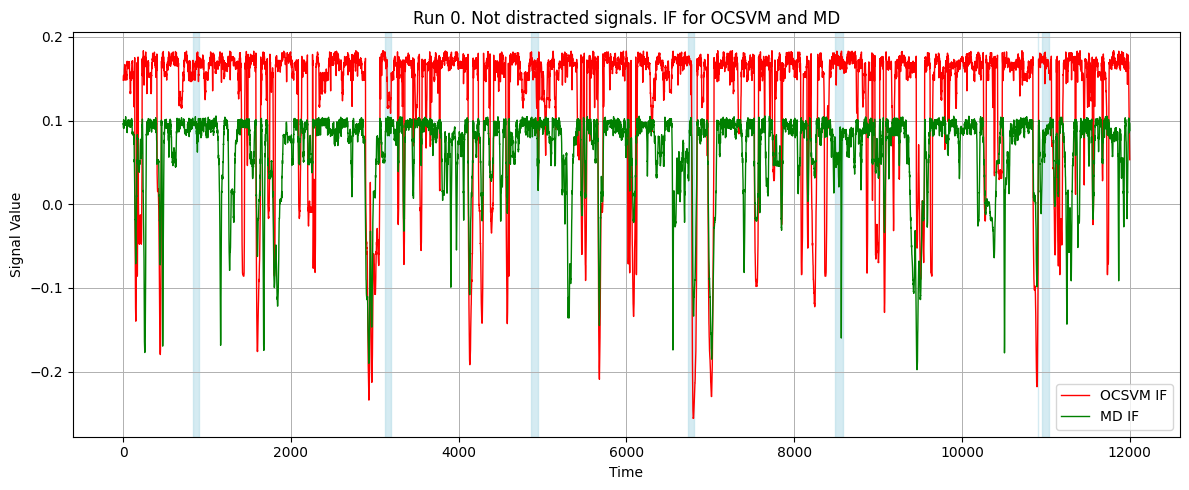

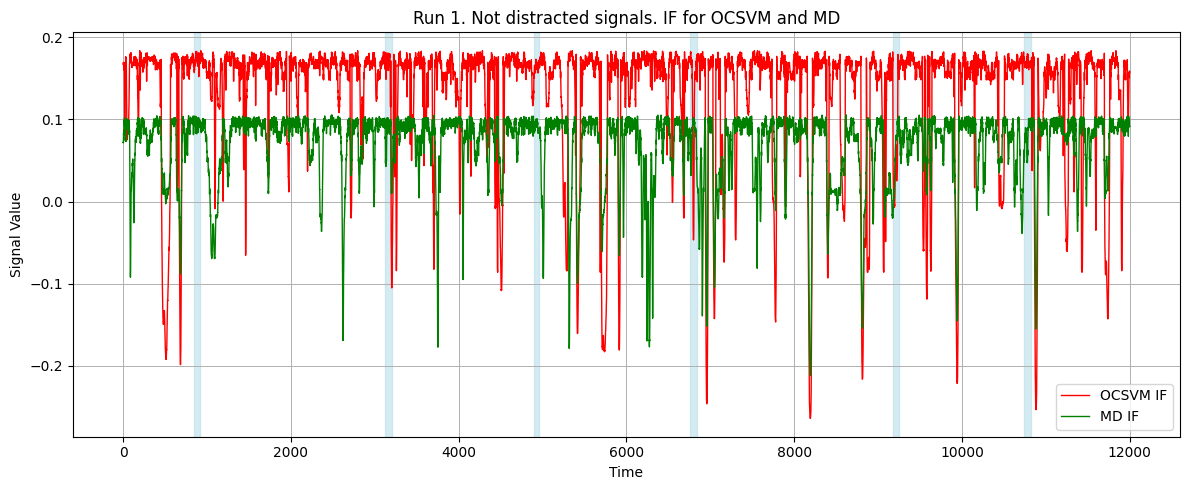

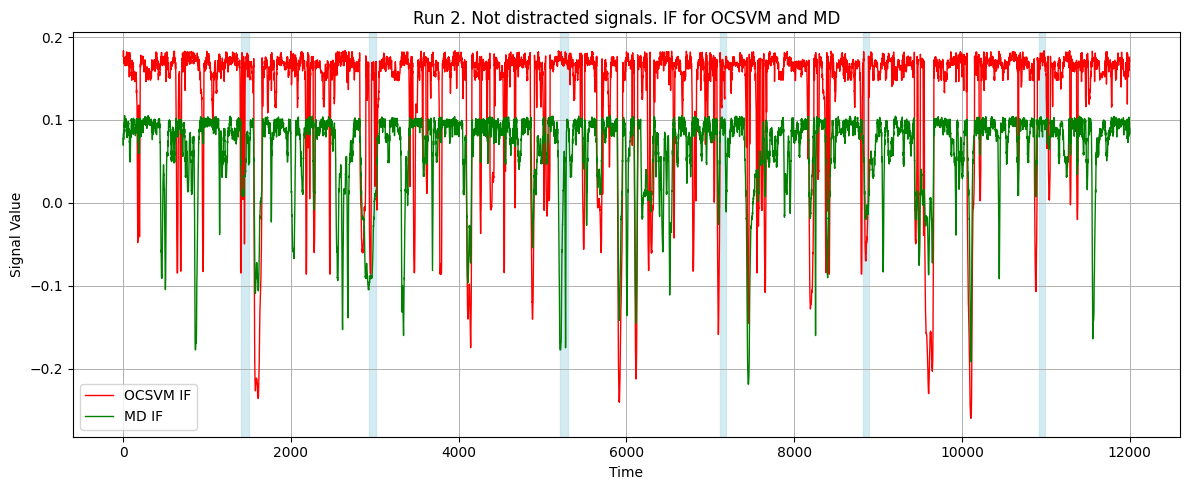

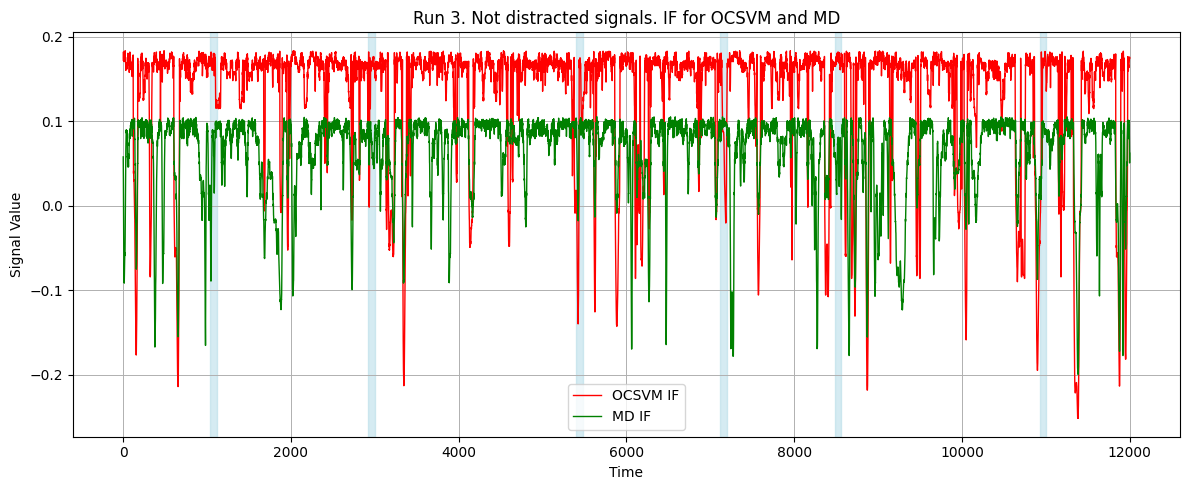

In [38]:
train_anomaly_scores_reshaped = [arr.reshape(40, 12000) for arr in train_anomaly_scores]
test_anomaly_scores_reshaped = [arr.reshape(40, 12000) for arr in test_anomaly_scores]

for idx in range(4):
    plot_signals_with_highlight(tc_test[:,idx], train_anomaly_scores_reshaped[0][idx,:], train_anomaly_scores_reshaped[1][idx,:],
                                label1="OCSVM IF", label2="MD IF", title=f"Run {idx}. Not distracted signals. IF for OCSVM and MD")

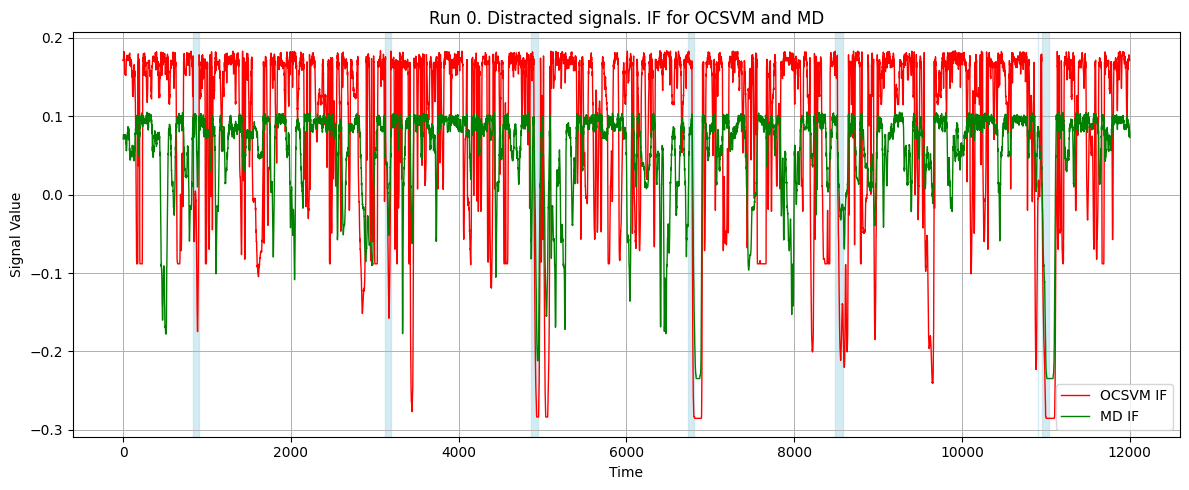

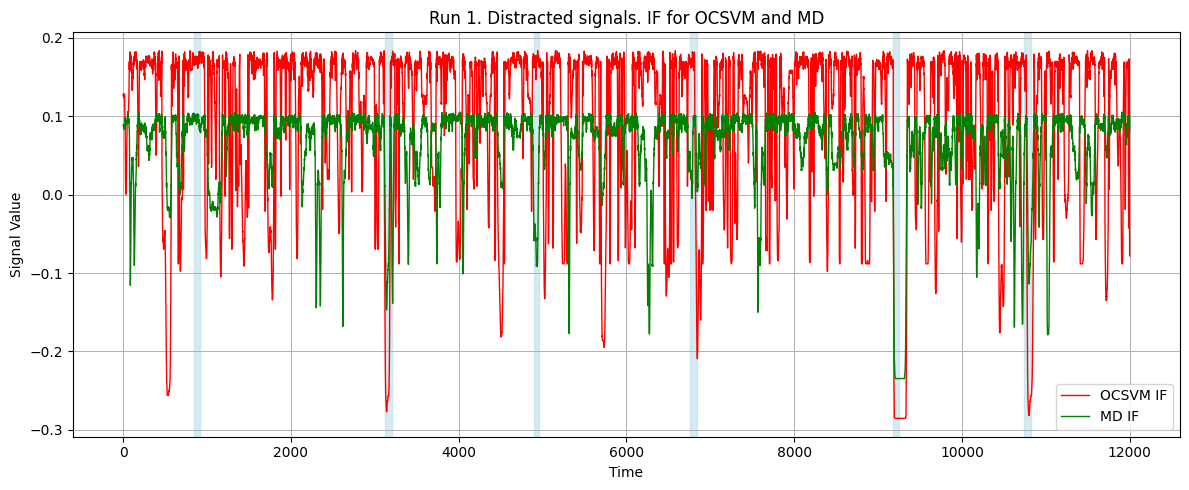

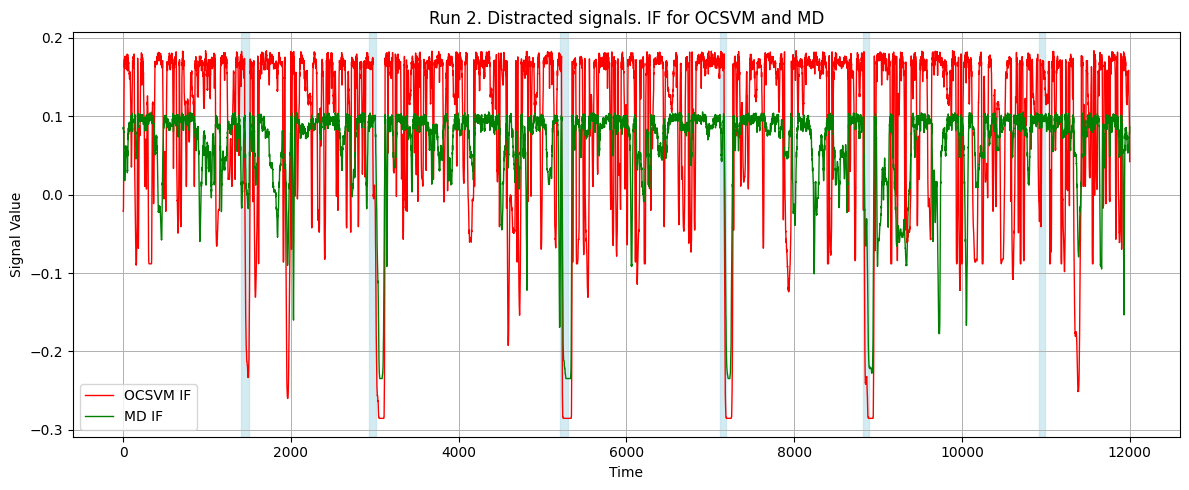

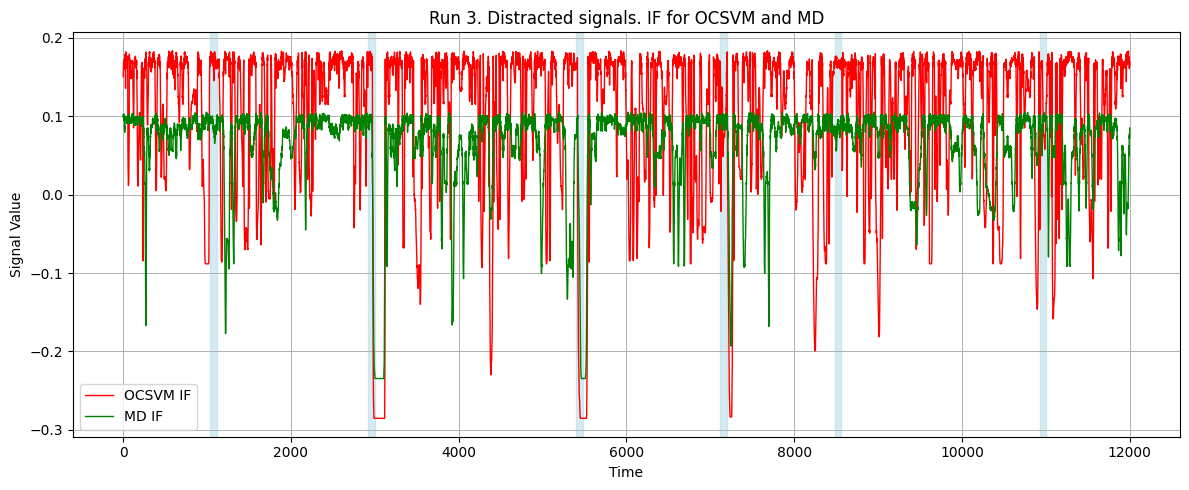

In [39]:
for idx in range(4):
    plot_signals_with_highlight(tc_test[:,idx], test_anomaly_scores_reshaped[0][idx,:], test_anomaly_scores_reshaped[1][idx,:],
                                label1="OCSVM IF", label2="MD IF", title=f"Run {idx}. Distracted signals. IF for OCSVM and MD")

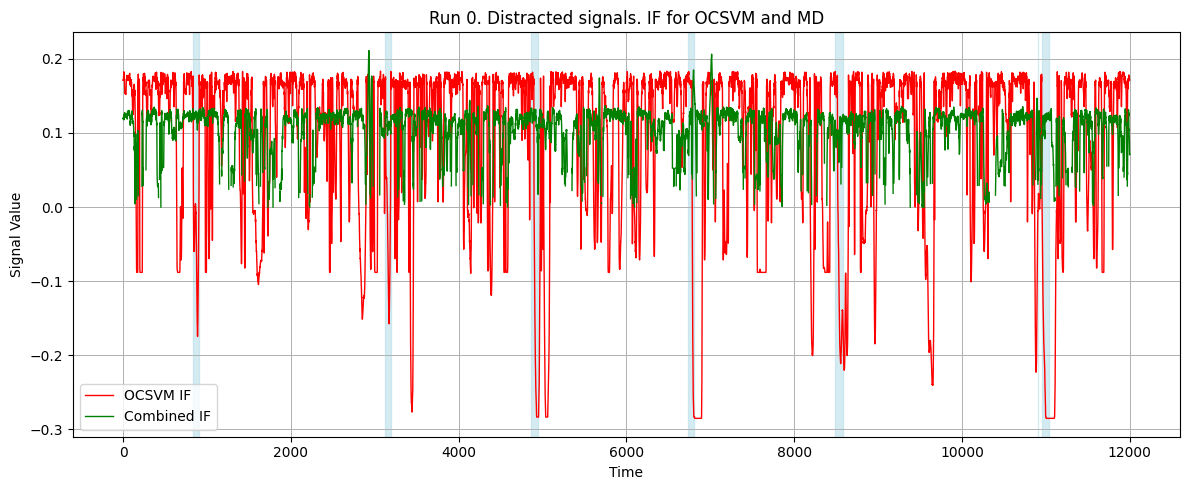

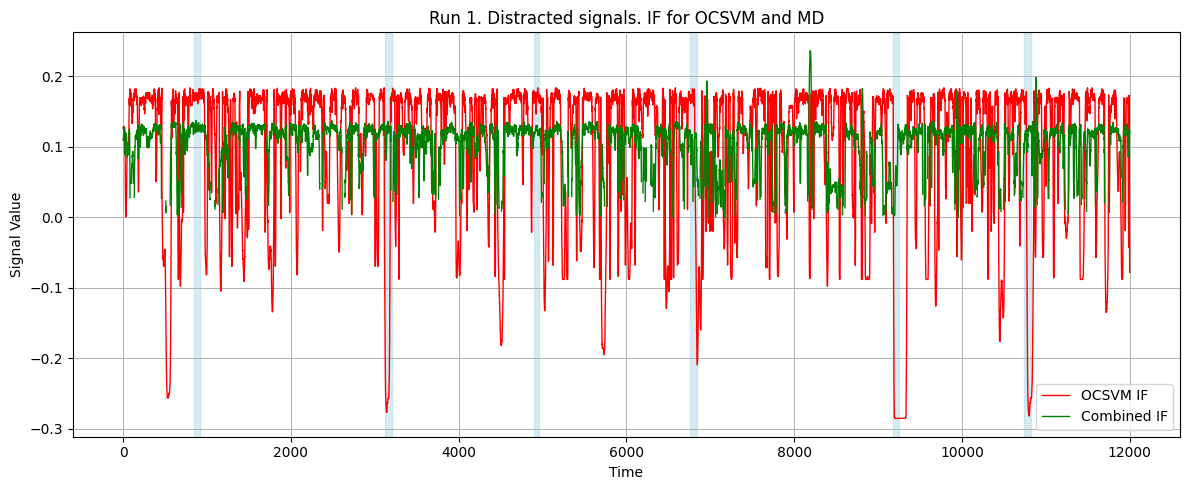

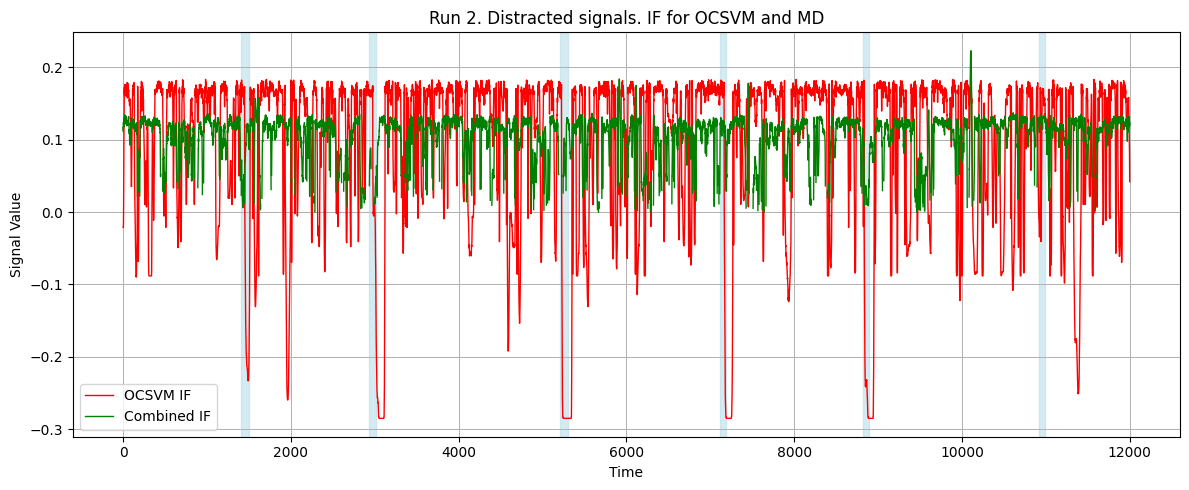

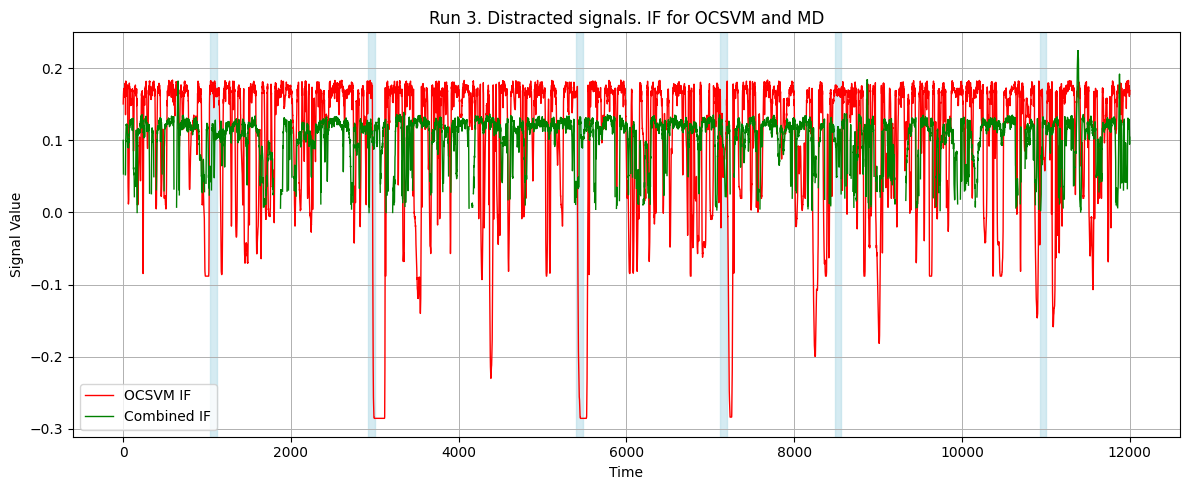

In [40]:
for idx in range(4):
    combined_scored = np.sqrt((train_anomaly_scores_reshaped[0][idx,:] * train_anomaly_scores_reshaped[1][idx,:]))
    plot_signals_with_highlight(tc_test[:,idx], test_anomaly_scores_reshaped[0][idx,:], combined_scored,
                                label1="OCSVM IF", label2="Combined IF", title=f"Run {idx}. Distracted signals. IF for OCSVM and MD")

## Modified performance scores

In [52]:
def match_changepoints_intervals(tc_true, tc_predicted):
    """
    Matches intervals of consecutive 1s between true and predicted changepoints
    (tc_true and tc_predicted) to evaluate detections, missed detections, and false alarms.
    
    Parameters:
    - tc_true: List[int], binary sequence representing true changepoint intervals
    - tc_predicted: List[int], binary sequence representing predicted changepoint intervals

    Returns:
    - matched: int, count of intervals with an overlap
    - missed: int, count of intervals in tc_true without a match
    - false_alarms: int, count of intervals in tc_predicted without a match
    """

    def get_intervals(binary_sequence):
        """Find intervals of consecutive 1s in a binary sequence."""
        intervals = []
        start = None
        for i, value in enumerate(binary_sequence):
            if value == 1 and start is None:
                start = i  # Start of a new interval
            elif value == 0 and start is not None:
                intervals.append((start, i - 1))  # End of interval
                start = None
        if start is not None:  # Handle case where sequence ends with 1
            intervals.append((start, len(binary_sequence) - 1))
        return intervals

    true_intervals = get_intervals(tc_true)
    pred_intervals = get_intervals(tc_predicted)

    matched = 0
    used_true_intervals = set()
    used_pred_intervals = set()

    # Match intervals based on overlap
    for i, true_interval in enumerate(true_intervals):
        for j, pred_interval in enumerate(pred_intervals):
            if j in used_pred_intervals:
                continue
            true_start, true_end = true_interval
            pred_start, pred_end = pred_interval

            # Check for overlap
            if not (pred_end < true_start or pred_start > true_end):  # Overlap exists
                matched += 1
                used_true_intervals.add(i)
                used_pred_intervals.add(j)
                break

    missed = len(true_intervals) - len(used_true_intervals)
    false_alarms = len(pred_intervals) - len(used_pred_intervals)

    return matched, missed, false_alarms

def match_changepoints_intervals_wrapper(tc_true, tc_predicted, nb_runs=40):
    """
    Wrapper function to match changepoints intervals for all runs.
    """
    matched_total, missed_total, false_alarms_total = 0, 0, 0

    for idx in range(nb_runs):
        #### TODO: remove this part which is hardcoded
        # due to the fact that run 19 is messy
        if idx == 19:
            continue

        matched, missed, false_alarms = match_changepoints_intervals(tc_true[idx,:], tc_predicted[idx,:])
        print(f"Run {idx}: matched={matched}, missed={missed}, false_alarms={false_alarms}")
        matched_total += matched
        missed_total += missed
        false_alarms_total += false_alarms

    return matched_total, missed_total, false_alarms_total


In [66]:
ocsvm_ewma = np.zeros(ocsvm_scores_matrix_distracted.shape)

for idx in range(40):
    ocsvm_ewma[idx,:] = exponential_window_accumulation(-ocsvm_scores_matrix_distracted[idx,:]/500, window_size=20, decay_factor=0.95)

print(f"{ocsvm_ewma.shape=}; {mahalanobis_distances_distracted.shape=}; {ocsvm_scores_matrix_distracted.shape=}")


ocsvm_ewma.shape=(40, 12000); mahalanobis_distances_distracted.shape=(40, 12000); ocsvm_scores_matrix_distracted.shape=(40, 12000)


In [67]:
evidence_function_ewma_windowed_all_runs = np.array([detect_distractions_mahalanobis_ewma_windowed(mahalanobis_distances_distracted[idx], chi_squared_limit=0.6) for idx in range(40)])

In [72]:
from performance_utils import *
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',').transpose()
ocsvm_ewma = exponential_window_accumulation(-ocsvm_scores_matrix_distracted/500, window_size=20, decay_factor=0.95)

# thresholds = np.arange(-1000, -1, 50)  # Threshold values to test
thresholds = np.arange(0.1, 3.1, 0.25)  # Threshold values to test

# Initialize result matrices
precisions = np.zeros(len(thresholds))
recalls = np.zeros(len(thresholds))
f1_scores = np.zeros(len(thresholds))

matches = np.zeros(len(thresholds))
misses = np.zeros(len(thresholds))
false_alarms_run = np.zeros(len(thresholds))

for th_idx, threshold in enumerate(thresholds): 
    # Accumulate results across runs (mean metrics over runs)
    matched, missed, false_alarms = match_changepoints_intervals_wrapper(tc_test, evidence_function_ewma_windowed_all_runs < threshold)
    matches[th_idx] = matched
    misses[th_idx] = missed
    false_alarms_run[th_idx] = false_alarms
    
    print(f"Threshold {threshold}: matched={matched}, missed={missed}, false_alarms={false_alarms}")
    precision, recall, f1_score = compute_precision_recall_f1_from_numbers(matched, missed, false_alarms)
    precisions[th_idx] = precision
    recalls[th_idx] = recall
    f1_scores[th_idx] = f1_score


Run 0: matched=4, missed=3, false_alarms=30
Run 1: matched=5, missed=1, false_alarms=30
Run 2: matched=6, missed=0, false_alarms=31
Run 3: matched=6, missed=0, false_alarms=24
Run 4: matched=4, missed=2, false_alarms=34
Run 5: matched=5, missed=1, false_alarms=35
Run 6: matched=4, missed=2, false_alarms=37
Run 7: matched=5, missed=1, false_alarms=34
Run 8: matched=4, missed=2, false_alarms=31
Run 9: matched=5, missed=1, false_alarms=23
Run 10: matched=5, missed=1, false_alarms=34
Run 11: matched=6, missed=2, false_alarms=19
Run 12: matched=5, missed=3, false_alarms=26
Run 13: matched=6, missed=3, false_alarms=18
Run 14: matched=6, missed=2, false_alarms=29
Run 15: matched=6, missed=5, false_alarms=29
Run 16: matched=6, missed=1, false_alarms=33
Run 17: matched=6, missed=0, false_alarms=55
Run 18: matched=7, missed=4, false_alarms=28
Run 20: matched=6, missed=1, false_alarms=41
Run 21: matched=6, missed=1, false_alarms=56
Run 22: matched=5, missed=1, false_alarms=48
Run 23: matched=5, m

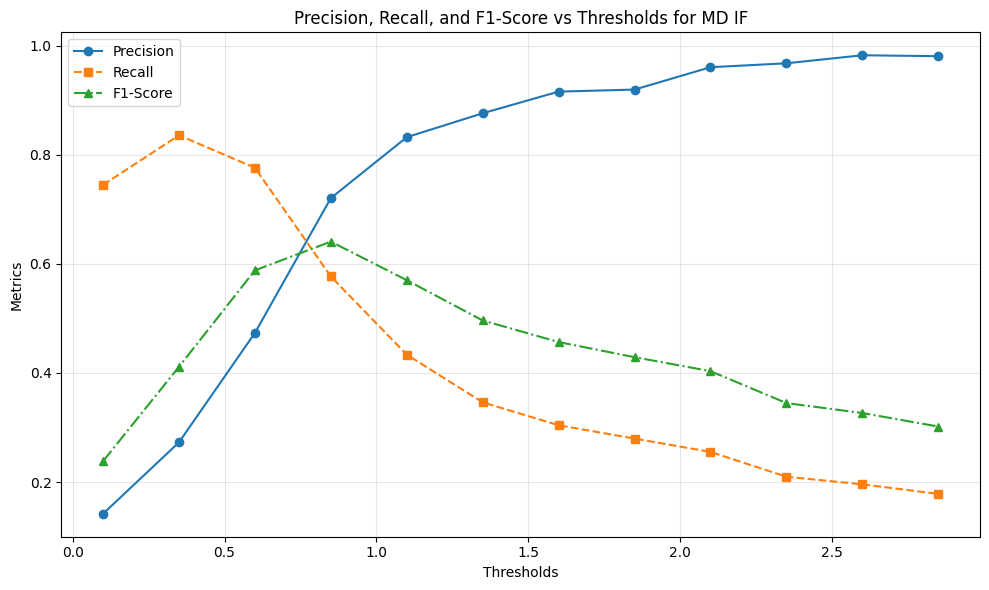

In [73]:
def plot_metrics(thresholds, precisions, recalls, f1_scores, title="Precision, Recall, and F1-Score vs Thresholds"):
    """
    Plots precision, recall, and F1-score against thresholds.

    Parameters:
    - thresholds: List or array of threshold values
    - precisions: List or array of precision values
    - recalls: List or array of recall values
    - f1_scores: List or array of F1-score values
    """
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', marker='o', linestyle='-')
    plt.plot(thresholds, recalls, label='Recall', marker='s', linestyle='--')
    plt.plot(thresholds, f1_scores, label='F1-Score', marker='^', linestyle='-.')

    # Add labels, title, legend, and grid
    plt.xlabel("Thresholds")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_metrics(thresholds, precisions, recalls, f1_scores, title="Precision, Recall, and F1-Score vs Thresholds for MD IF")

In [75]:
def get_intervals(binary_sequence):
        """Find intervals of consecutive 1s in a binary sequence."""
        intervals = []
        start = None
        for i, value in enumerate(binary_sequence):
            if value == 1 and start is None:
                start = i  # Start of a new interval
            elif value == 0 and start is not None:
                intervals.append((start, i - 1))  # End of interval
                start = None
        if start is not None:  # Handle case where sequence ends with 1
            intervals.append((start, len(binary_sequence) - 1))
        return intervals

all_intervals = []
for idx in range(40):
    if idx == 19:
        continue
    true_intervals = get_intervals(tc_test[idx,:])
    all_intervals.extend(true_intervals)

print(len(all_intervals))

interval_lengths = [end - start + 1 for start, end in all_intervals]

# Compute the average length
average_length = sum(interval_lengths) / len(interval_lengths) if interval_lengths else 0

print(f"Average length of intervals: {average_length}")

286
Average length of intervals: 54.03146853146853
